In [1]:
"""Scripts for analyzing of phantom outputs.

This script generate lightcurves (LC) by doing radiative transfer on a grid.

"""

'Scripts for analyzing of phantom outputs.\n\nThis script generate lightcurves (LC) by doing radiative transfer on a grid.\n\n'

.

# Def

.

## Imports & Settings

In [2]:
import numpy as np
from numpy import pi
from astropy import units
from astropy import constants as const
import matplotlib.pyplot as plt
import matplotlib as mpl
from numba import jit
import sarracen
import itertools
from scipy import integrate, fft
from scipy.spatial import kdtree
from datetime import datetime
#from moviepy.editor import ImageSequenceClip
#from os import path

/home/clmu/anaconda3/envs/clmu_1/lib/python3.11/site-packages/sarracen/kernels/cubic_spline.py:15: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(fastmath=True)
/home/clmu/anaconda3/envs/clmu_1/lib/python3.11/site-packages/sarracen/kernels/quartic_spline.py:15: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(fastmath=True)
/home/clmu/anaconda3/envs/clmu_1

In [3]:
# import my modules listed in ./main/

import clmuphantomlib as mupl
from clmuphantomlib            import MyPhantomDataFrames, get_eos
from clmuphantomlib.log        import is_verbose, say
from clmuphantomlib.settings   import DEFAULT_SETTINGS as settings
from clmuphantomlib.units_util import get_val_in_unit, set_as_quantity #, get_units_field_name, get_units_cgs
from clmuphantomlib.readwrite  import json_dump, json_load
from clmuphantomlib.eos_mesa   import EoS_MESA_opacity
from clmuphantomlib.light      import get_optical_depth_by_ray_tracing_3D, get_photosphere_on_ray

from multiprocessing import cpu_count, Pool #Process, Queue
NPROCESSES = 1 if cpu_count() is None else max(cpu_count(), 1)

/mnt/d/Sync_OneDrive/Macquarie University/Project RT in CEE - Docs/Projects/20230201/src/clmuphantomlib/sph_interp.py:36: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(nopython=False)
/mnt/d/Sync_OneDrive/Macquarie University/Project RT in CEE - Docs/Projects/20230201/src/clmuphantomlib/sph_interp.py:49: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(

In [4]:
# settings
#
#   imported from script_input.py file


from script_LCGen__input import verbose, interm_dir, output_dir, unitsOut, PHOTOSPHERE_TAU, JOB_PROFILES_DICT
from _sharedFuncs import mpdf_read

unitsOutTxt = {  key  : unitsOut[key].to_string('latex_inline') for key in unitsOut.keys() }


# set metadata
with open("_metadata__input.json", 'r') as f:
    metadata = json_load(f)
metadata['Title'] = "Getting light curves by intergrating across a grid of rays"
metadata['Description'] = f"""Getting light curves by intergrating across a grid of rays with the same directions
for dump file data generated by phantom
"""


plt.rcParams.update({'font.size': 20})
if __name__ == '__main__' and is_verbose(verbose, 'note'):
    # remember to check if name is '__main__' if you wanna say anything
    #    so when you do multiprocessing the program doesn't freak out
    say('note', "script", verbose, f"Will use {NPROCESSES} processes for parallelization")


*   Note   :    script:
	Will use 8 processes for parallelization


In [5]:
from clmuphantomlib.log import say, is_verbose
from clmuphantomlib.geometry import get_dist2_between_2pt, get_closest_pt_on_line
from clmuphantomlib.sph_interp import get_sph_interp, get_h_from_rho, get_no_neigh, _get_sph_interp_phantom_np
from clmuphantomlib.units_util import set_as_quantity, set_as_quantity_temperature, get_units_field_name
from clmuphantomlib.eos_base import EoS_Base
from clmuphantomlib.light import integrate_along_ray_grid, integrate_along_ray_gridxy

#  import (general)
import numpy as np
import numba
from numba import jit, prange
import sarracen

from clmuphantomlib.geometry import get_dist2_from_pts_to_line, get_dist2_from_pt_to_line_nb, get_ray_unit_vec, get_rays_unit_vec

## Functions

### LC integration

#### Backup codes

In [6]:
@jit(nopython=False)
def integrate_along_ray(
    sdf, ray, srcfuncs, photosphere_tau=1.,
    verbose: int = 3,
):
    pts_on_ray, dtaus, pts_order = get_optical_depth_by_ray_tracing_3D(sdf=sdf, ray=ray)
    if is_verbose(verbose, 'debug'):
        say('debug', None, verbose, 'optical depth got.')

    dtaus_ordered = dtaus[pts_order]
    if is_verbose(verbose, 'debug'):
        say('debug', None, verbose, 'ordered.')
    srcfuncs_ordered = srcfuncs[pts_order]
    if is_verbose(verbose, 'debug'):
        say('debug', None, verbose, 'srcfuncs_ordered.')
    dat_steps = np.full_like(dtaus_ordered, np.nan)

    if True:
    #if backwards:
        # closest to observer to furtherest
        dat = 0.
        taus_ordered = np.array([0., *np.cumsum(dtaus_ordered[:-1])])
        # dat_bwd_inc: dat_backward_contributions
        dat_bwd_inc = np.exp(-taus_ordered) * (1 - np.exp(-dtaus_ordered)) * srcfuncs_ordered
        dat = np.sum(dat_bwd_inc)
        if is_verbose(verbose, 'info'):
            say('info', None, verbose,
                f"backward dat = {dat}")    # debug
        if False:
            # commented
            # get the percentage of contribution to lum from photosphere outwards
            photosphere_loc_index = np.searchsorted(taus_ordered, photosphere_tau) - 1
            photosphere_contri_percent = np.sum(dat_bwd_inc[:photosphere_loc_index+2]) / dat * 100
            dat_percent_index = np.where(np.cumsum(dat_bwd_inc) / dat<0.5)[0][-1]
            if is_verbose(verbose, 'info'):
                say('info', None, verbose,
                    f"\tContribution to L from photosphere and outwards is: {photosphere_contri_percent} %",
                    f"\t50% Contributed correspond to tau = {taus_ordered[dat_percent_index]} ")
        taus_ordered = taus_ordered[::-1]

    else:
        # furtherest to observer to closest
        dat = 0.
        #  pts_order[::-1]: reverse pts_order so that the furtherest particles comes first
        taus_ordered = np.array([0., *np.cumsum(dtaus_ordered[:-1])])[::-1]
        exp_mdtaus_r = np.exp(-dtaus_ordered[::-1])
        srcfuncs_ordered_r = srcfuncs_ordered[::-1]
        for index, srcfunc in enumerate(srcfuncs_ordered_r):
            exp_mdtau = exp_mdtaus_r[index]
            dat = exp_mdtau * dat + (1-exp_mdtau) * srcfunc
            dat_steps[index] = dat
        if is_verbose(verbose, 'info'):
            say('info', None, verbose,
                f"forward dat = {dat}")    # debug
        
    dtaus_ordered = dtaus_ordered[::-1]
    pts_order = pts_order[::-1]  # furtherest to observer to closest
    pts_on_ray_ordered = pts_on_ray[pts_order]
    
    
    return  pts_order, pts_on_ray, dtaus_ordered, taus_ordered, \
            dat, dat_steps, dat_bwd_inc

In [7]:
@jit(nopython=False)
def integrate_error_along_ray(
    dtaus_ordered, # furtherest to closest
    srcfuncs_ordered, srcfuncs_ordered_errp, srcfuncs_ordered_errm,
    photosphere_tau=1.,
):
    #if backwards:
    if True:
        
        # closest to observer to furtherest
        dtaus_ordered = dtaus_ordered[::-1]
        
        # calc data + error
        taus_ordered = np.array([0., *np.cumsum(dtaus_ordered[:-1])])
        srcfuncs_errs = np.stack([srcfuncs_ordered, srcfuncs_ordered_errp, srcfuncs_ordered_errm])
        srcfuncs_errs = np.flip(srcfuncs_errs, axis=-1) # flip it since we are working backwards
        dat_bwd_inc_errs = np.exp(-taus_ordered) * (1 - np.exp(-dtaus_ordered)) * srcfuncs_errs
        dat_errs = np.sum(dat_bwd_inc_errs, axis=-1)
        
        dat_bwd_inc_errs = np.flip(dat_bwd_inc_errs, axis=-1)
        
        if False:
            # get data
            dat_bwd_inc = dat_bwd_inc_errs[0]
            dat = dat_errs[0]
            dat_errp = dat_errs[1]
            dat_errm = dat_errs[2]
        

    else:
        raise NotImplementedError()
        # furtherest to observer to closest
        dat = 0.
        dat_steps = np.full_like(dtaus_ordered, np.nan)
        #  pts_order[::-1]: reverse pts_order so that the furtherest particles comes first
        taus_ordered = np.array([0., *np.cumsum(dtaus_ordered[:-1])])[::-1]
        exp_mdtaus_r = np.exp(-dtaus_ordered[::-1])
        srcfuncs_ordered_r = srcfuncs_ordered[::-1]
        for index, srcfunc in enumerate(srcfuncs_ordered_r):
            exp_mdtau = exp_mdtaus_r[index]
            dat = exp_mdtau * dat + (1-exp_mdtau) * srcfunc
            dat_steps[index] = dat
        print("forward dat = ", dat)    # debug
        
    #dtaus_ordered = dtaus_ordered[::-1]
    return dat_errs, dat_bwd_inc_errs

#### Test codes

In [8]:
# test runs
@jit(nopython=True, parallel=True)
def _integrate_along_ray_gridxy_sub_parallel_analysis_test(
    pts_ordered          : np.ndarray,    # (npart, 3)-shaped
    hs_ordered           : np.ndarray,    # (npart,  )-shaped
    mkappa_div_h2_ordered: np.ndarray,    # (npart,  )-shaped
    srcfuncs_ordered     : np.ndarray,    # (npart,  )-shaped
    rays                 : np.ndarray,    # (nray, 2, 3)-shaped
    kernel_rad           : float,
    col_kernel           : numba.core.registry.CPUDispatcher,
    pts_order            : np.ndarray,    # (npart,  )-shaped
    rel_tol              : float = 1e-15, # because float64 is only has only 16 digits accuracy
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Sub process for integrate_along_ray_gridxy(). Numba parallel version (using prange).

    Unit vec must be [0., 0., 1.] (i.e. all rays must point upwards towards +z).

    Private function. Assumes specific input type. See source code comments.

    """
    #raise NotImplementedError

    nray  = len(rays)
    npart = len(srcfuncs_ordered)
    ndim  = pts_ordered.shape[-1]
    anses = np.zeros(nray)
    indes = np.zeros(nray, dtype=np.int64)    # indexes of max contribution particle
    contr = np.zeros(nray)    # contribution of the max contribution particle
    jused = np.full(npart, False)    # is j-th particle in the ordered list used for this calculation?

    # error tolerance of tau (part 1)
    tol_tau_base = np.log(srcfuncs_ordered.sum()) - np.log(rel_tol)

    # hr = h * kernel_rad
    hrs_ordered = hs_ordered * kernel_rad

    # loop over ray
    for i in prange(nray):
        ray = rays[i]
        tau = 0.
        ans = 0.
        dans= 0.
        dans_max_tmp = 0.
        ind = -1

        #   xy-grid specific solution
        ray_x = ray[0, 0]
        ray_y = ray[0, 1]
        
        # loop over particles
        #for pt, hr, mkappa_div_h2, srcfunc in zip(
        #    pts_ordered, hrs_ordered, mkappa_div_h2_ordered, srcfuncs_ordered):
        for j in range(npart):
            pt = pts_ordered[j]
            hr = hrs_ordered[j]
            
            # check if the particle is within range
            #   general solution
            #q = get_dist2_from_pt_to_line_nb(pt, ray)**0.5 / h
            #if q < kernel_rad:
            #   xy-grid specific solution
            if ray_x - hr < pt[0] and pt[0] < ray_x + hr and ray_y - hr < pt[1] and pt[1] < ray_y + hr:
                h = hs_ordered[ j]
                q = ((pt[0] - ray_x)**2 + (pt[1] - ray_y)**2)**0.5 / h
                if q < kernel_rad:

                    jused[j] = True
                    
                    # now do radiative transfer
                    
                    mkappa_div_h2 = mkappa_div_h2_ordered[j]
                    srcfunc = srcfuncs_ordered[j]
                    
                    dtau = mkappa_div_h2 * col_kernel(q, ndim-1)
                    tau += dtau/2.
                    dans = np.exp(-tau) * dtau * srcfunc
                    ans += dans
                    tau += dtau/2.

                    # note down the largest contributor
                    if dans > dans_max_tmp:
                        dans_max_tmp = dans
                        ind = pts_order[j]
    
                    # terminate the calc for this ray if tau is sufficient large
                    #    such that the relative error on ans is smaller than rel_tol
                    # i.e. since when tau > np.log(srcfuncs_ordered.sum()) - np.log(rel_tol) - np.log(ans),
                    #    we know that ans[i] - ans[i][k] < rel_tol * ans[i]
                    # see my notes for derivation
                    if tau > tol_tau_base - np.log(ans):
                        break
            
        anses[i] = ans
        indes[i] = ind
        contr[i] = dans_max_tmp / ans
    
    return anses, indes, contr, jused


#_integrate_along_ray_gridxy_sub_parallel_analysis = _integrate_along_ray_gridxy_sub_parallel_analysis_test

#### Actual code

In [9]:
@jit(nopython=True, parallel=True)
def _integrate_along_ray_gridxy_sub_parallel_analysis(
    pts_ordered          : np.ndarray,    # (npart, 3)-shaped
    hs_ordered           : np.ndarray,    # (npart,  )-shaped
    mkappa_div_h2_ordered: np.ndarray,    # (npart,  )-shaped
    srcfuncs_ordered     : np.ndarray,    # (npart,  )-shaped
    rays                 : np.ndarray,    # (nray, 2, 3)-shaped
    kernel_rad           : float,
    col_kernel           : numba.core.registry.CPUDispatcher,
    pts_order            : np.ndarray,    # (npart,  )-shaped
    rel_tol              : float = 1e-15, # because float64 is only has only 16 digits accuracy
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Sub process for integrate_along_ray_gridxy(). Numba parallel version (using prange).

    Unit vec must be [0., 0., 1.] (i.e. all rays must point upwards towards +z).

    Private function. Assumes specific input type. See source code comments.

    """
    #raise NotImplementedError

    nray  = len(rays)
    npart = len(srcfuncs_ordered)
    ndim  = pts_ordered.shape[-1]
    anses = np.zeros(nray)
    indes = np.zeros(nray, dtype=np.int64)    # indexes of max contribution particle
    contr = np.zeros(nray)    # contribution of the max contribution particle
    jused = np.full(npart, False)    # is j-th particle in the ordered list used for this calculation?

    # error tolerance of tau (part 1)
    tol_tau_base = np.log(srcfuncs_ordered.sum()) - np.log(rel_tol)

    # hr = h * kernel_rad
    hrs_ordered = hs_ordered * kernel_rad

    # loop over ray
    for i in prange(nray):
        ray = rays[i]
        tau = 0.
        ans = 0.
        dans= 0.
        dans_max_tmp = 0.
        ind = -1

        #   xy-grid specific solution
        ray_x = ray[0, 0]
        ray_y = ray[0, 1]
        
        # loop over particles
        #for pt, hr, mkappa_div_h2, srcfunc in zip(
        #    pts_ordered, hrs_ordered, mkappa_div_h2_ordered, srcfuncs_ordered):
        for j in range(npart):
            pt = pts_ordered[j]
            hr = hrs_ordered[j]
            
            # check if the particle is within range
            #   general solution
            #q = get_dist2_from_pt_to_line_nb(pt, ray)**0.5 / h
            #if q < kernel_rad:
            #   xy-grid specific solution
            if ray_x - hr < pt[0] and pt[0] < ray_x + hr and ray_y - hr < pt[1] and pt[1] < ray_y + hr:
                h = hs_ordered[ j]
                q = ((pt[0] - ray_x)**2 + (pt[1] - ray_y)**2)**0.5 / h
                if q < kernel_rad:

                    jused[j] = True
                    
                    # now do radiative transfer
                    
                    mkappa_div_h2 = mkappa_div_h2_ordered[j]
                    srcfunc = srcfuncs_ordered[j]
                    
                    dtau = mkappa_div_h2 * col_kernel(q, ndim-1)
                    tau += dtau/2.
                    dans = np.exp(-tau) * (1. - np.exp(-dtau)) * srcfunc
                    ans += dans
                    tau += dtau/2.

                    # note down the largest contributor
                    if dans > dans_max_tmp:
                        dans_max_tmp = dans
                        ind = pts_order[j]
    
                    # terminate the calc for this ray if tau is sufficient large
                    #    such that the relative error on ans is smaller than rel_tol
                    # i.e. since when tau > np.log(srcfuncs_ordered.sum()) - np.log(rel_tol) - np.log(ans),
                    #    we know that ans[i] - ans[i][k] < rel_tol * ans[i]
                    # see my notes for derivation
                    if tau > tol_tau_base - np.log(ans):
                        break
            
        anses[i] = ans
        indes[i] = ind
        contr[i] = dans_max_tmp / ans
    
    return anses, indes, contr, jused


In [10]:
@jit(nopython=True, parallel=True)
def _integrate_along_ray_gridxy_sub_parallel_err_ind(
    pts_ordered          : np.ndarray,    # (npart, 3)-shaped
    hs_ordered           : np.ndarray,    # (npart,  )-shaped
    mkappa_div_h2_ordered: np.ndarray,    # (npart,  )-shaped
    srcfuncs_ordered     : np.ndarray,    # (npart,  )-shaped
    srcfuncs_err_ordered : np.ndarray,    # (npart,  )-shaped
    rays                 : np.ndarray,    # (nray, 2, 3)-shaped
    kernel_rad           : float,
    col_kernel           : numba.core.registry.CPUDispatcher,
    pts_order            : np.ndarray,    # (npart,  )-shaped
    rel_tol              : float = 1e-15, # because float64 is only has only 16 digits accuracy
) -> tuple[np.ndarray, np.ndarray]:
    """Sub process for integrate_along_ray_gridxy(). Numba parallel version (using prange).

    Unit vec must be [0., 0., 1.] (i.e. all rays must point upwards towards +z).

    Private function. Assumes specific input type. See source code comments.

    """
    #raise NotImplementedError

    nray  = len(rays)
    npart = len(srcfuncs_ordered)
    ndim  = pts_ordered.shape[-1]
    anses = np.zeros(nray)
    erres = np.zeros(nray)

    # error tolerance of tau (part 1)
    tol_tau_base = np.log(srcfuncs_ordered.sum()) - np.log(rel_tol)

    # hr = h * kernel_rad
    hrs_ordered = hs_ordered * kernel_rad

    # loop over ray
    for i in prange(nray):
        ray = rays[i]
        tau = 0.
        ans = 0.
        err = 0.
        dans= 0.

        #   xy-grid specific solution
        ray_x = ray[0, 0]
        ray_y = ray[0, 1]
        
        # loop over particles
        #for pt, hr, mkappa_div_h2, srcfunc in zip(
        #    pts_ordered, hrs_ordered, mkappa_div_h2_ordered, srcfuncs_ordered):
        for j in range(npart):
            pt = pts_ordered[j]
            hr = hrs_ordered[j]
            
            # check if the particle is within range
            #   general solution
            #q = get_dist2_from_pt_to_line_nb(pt, ray)**0.5 / h
            #if q < kernel_rad:
            #   xy-grid specific solution
            if ray_x - hr < pt[0] and pt[0] < ray_x + hr and ray_y - hr < pt[1] and pt[1] < ray_y + hr:
                h = hs_ordered[ j]
                q = ((pt[0] - ray_x)**2 + (pt[1] - ray_y)**2)**0.5 / h
                if q < kernel_rad:
                    
                    # now do radiative transfer
                    
                    mkappa_div_h2 = mkappa_div_h2_ordered[j]
                    srcfunc = srcfuncs_ordered[j]
                    srcfunc_err = srcfuncs_err_ordered[j]

                    dtau = mkappa_div_h2 * col_kernel(q, ndim-1)
                    tau += dtau/2.
                    dans = np.exp(-tau) * (1. - np.exp(-dtau)) * srcfunc
                    err += np.exp(-tau) * (1. - np.exp(-dtau)) * srcfunc_err
                    ans += dans
                    tau += dtau/2.
    
                    # terminate the calc for this ray if tau is sufficient large
                    #    such that the relative error on ans is smaller than rel_tol
                    # i.e. since when tau > np.log(srcfuncs_ordered.sum()) - np.log(rel_tol) - np.log(ans),
                    #    we know that ans[i] - ans[i][k] < rel_tol * ans[i]
                    # see my notes for derivation
                    if tau > tol_tau_base - np.log(ans):
                        break
            
        anses[i] = ans
        erres[i] = err
    
    return anses, erres


#### integrate only, no error estiamtes (faster)

In [44]:
# integrate only, no error estiamtes

@jit(nopython=False)
def integrate_along_ray_gridxy_ind(
    sdf     : sarracen.SarracenDataFrame,
    srcfuncs: np.ndarray,
    rays    : np.ndarray,
    ray_unit_vec: np.ndarray|None = None,
    kernel  : sarracen.kernels.BaseKernel = None,
    parallel: bool = True,
    err_h   : float = 1.0,
    rel_tol : float = 1e-15,
    sdf_kdtree : kdtree.KDTree = None,
    xyzs_names_list : list = ['x', 'y', 'z'],
    verbose : int = 3,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Backward integration of source functions along a grided ray (traced backwards), weighted by optical depth.
    
    Assuming all rays facing +z direction. (with the same ray_unit_vec [0., 0., 1.])
    
    
    Parameters
    ----------
    sdf: sarracen.SarracenDataFrame
        Must contain columns: x, y, z, h, m, kappa
        
    rays: (nray, 2, 3)-shaped array
        Representing the ray trajectory. Currently only straight infinite lines are supported.
        each ray is of the format:
        [[begin point], [end point]]
        where the end point is closer to the observer.

    srcfuncs: 1D array
        arrays describing the source function for every particle
        
    kernel: sarracen.kernels.base_kernel
        Smoothing kernel for SPH data interpolation.
        If None, will use the one in sdf.

    parallel: bool
        If to use the numba parallel function

    err_h: float ( > 0. )
        determine confidence level.
        e.g.,
            1.0 will give error assuming error range is +/-1.0 smoothing length h;
            0.5 will give error assuming error range is +/-0.5 smoothing length h;
            etc. etc.
            
    rel_tol : float
        maximum relative error tolerence per ray.
        Default 1e-15 because float64 is only accurate to ~16th digits.

    sdf_kdtree : kdtree.KDTree
        KDTree built from sdf[['x', 'y', 'z']], for fast neighbour search.
        
    xyzs_names_list: list
        list of names of the columns that represents x, y, z axes (i.e. coord axes names)
        MUST INCLUDE ALL THREE AXES LABELS.
        If only 2 is included, WILL ASSUME IT IS 2D CACULATIONS.
    
    Returns
    -------
    anses, indes, contr, pts_order_used
    
    anses: np.ndarray
        Radiance (i.e. specific intensities) for each ray.
    
    """


    # init
    npart : int = len(sdf)
    nray  : int = len(rays)
    if kernel is None: kernel = sdf.kernel
    kernel_rad = float(kernel.get_radius())
    col_kernel = kernel.get_column_kernel_func(samples=1000) # w integrated from z
    if ray_unit_vec is None: ray_unit_vec = get_ray_unit_vec(rays[0])
    
    pts    = np.array(sdf[xyzs_names_list], order='C')    # (npart, 3)-shaped array (must be this shape for pts_order sorting below)
    hs     = np.array(sdf[ 'h'           ], order='C')    # npart-shaped array
    masses = np.array(sdf[ 'm'           ], order='C')
    kappas = np.array(sdf[ 'kappa'       ], order='C')
    srcfuncs = np.array(srcfuncs          , order='C')
    ndim   = pts.shape[-1]
    mkappa_div_h2_arr = masses * kappas / hs**(ndim-1)
    
    # sanity check
    if is_verbose(verbose, 'err') and not np.allclose(ray_unit_vec, get_rays_unit_vec(rays)):
        raise ValueError(f"Inconsistent ray_unit_vec {ray_unit_vec} with the rays.")

    if is_verbose(verbose, 'warn') and ndim != 3:
        say('warn', 'integrate_along_ray_gridxy_err_ind()', verbose, f"ndim == {ndim} is not 3.")

    # (npart-shaped array of the indices of the particles from closest to the observer to the furthest)
    pts_order             = np.argsort( np.sum(pts * ray_unit_vec, axis=-1) )[::-1]
    pts_ordered           = pts[     pts_order]
    hs_ordered            = hs[      pts_order]
    mkappa_div_h2_ordered = mkappa_div_h2_arr[pts_order]
    srcfuncs_ordered      = srcfuncs[pts_order]

    # get used particles indexes
    anses, indes, contr, jused = _integrate_along_ray_gridxy_sub_parallel_analysis(
        pts_ordered, hs_ordered, mkappa_div_h2_ordered, srcfuncs_ordered, rays, kernel_rad, col_kernel, pts_order, rel_tol=rel_tol)

    pts_order_used = pts_order[jused]
    if is_verbose(verbose, 'info'):
        nused = len(pts_order_used)
        say('info', 'integrate_along_ray_gridxy_err_ind()', verbose,
            f"{nused} particles actually participated calculation",
            f"({int(nused/npart*10000)/100.}% of all particles,",
            f"average {int(nused/nray*100)/100.} per ray.)", sep=' ')

    
    return anses, indes, contr, pts_order_used


#### integrate with error estiamtes

In [12]:
# integrate and integrate error

#@jit(nopython=False)
def integrate_along_ray_gridxy_err_ind(
    sdf     : sarracen.SarracenDataFrame,
    srcfuncs: np.ndarray,
    rays    : np.ndarray,
    ray_unit_vec: np.ndarray|None = None,
    kernel  : sarracen.kernels.BaseKernel = None,
    parallel: bool = True,
    err_h   : float = 1.0,
    rel_tol : float = 1e-15,
    sdf_kdtree : kdtree.KDTree = None,
    xyzs_names_list : list = ['x', 'y', 'z'],
    verbose : int = 3,
) -> tuple[np.ndarray, np.ndarray]:
    """Backward integration of source functions along a grided ray (traced backwards), weighted by optical depth.
    
    Assuming all rays facing +z direction. (with the same ray_unit_vec [0., 0., 1.])
    
    
    Parameters
    ----------
    sdf: sarracen.SarracenDataFrame
        Must contain columns: x, y, z, h, m, kappa
        
    rays: (nray, 2, 3)-shaped array
        Representing the ray trajectory. Currently only straight infinite lines are supported.
        each ray is of the format:
        [[begin point], [end point]]
        where the end point is closer to the observer.

    srcfuncs: 1D array
        arrays describing the source function for every particle
        
    kernel: sarracen.kernels.base_kernel
        Smoothing kernel for SPH data interpolation.
        If None, will use the one in sdf.

    parallel: bool
        If to use the numba parallel function

    err_h: float ( > 0. )
        determine confidence level.
        e.g.,
            1.0 will give error assuming error range is +/-1.0 smoothing length h;
            0.5 will give error assuming error range is +/-0.5 smoothing length h;
            etc. etc.
            
    rel_tol : float
        maximum relative error tolerence per ray.
        Default 1e-15 because float64 is only accurate to ~16th digits.

    sdf_kdtree : kdtree.KDTree
        KDTree built from sdf[['x', 'y', 'z']], for fast neighbour search.
        
    xyzs_names_list: list
        list of names of the columns that represents x, y, z axes (i.e. coord axes names)
        MUST INCLUDE ALL THREE AXES LABELS.
        If only 2 is included, WILL ASSUME IT IS 2D CACULATIONS.
    
    Returns
    -------
    rads, errs
    
    rads: np.ndarray
        Radiance (i.e. specific intensities) for each ray.

    errs: np.ndarray
        Uncertainties of Radiance (i.e. specific intensities) for each ray.
    
    """


    # init
    npart : int = len(sdf)
    nray  : int = len(rays)
    if kernel is None: kernel = sdf.kernel
    kernel_rad = float(kernel.get_radius())
    col_kernel = kernel.get_column_kernel_func(samples=1000) # w integrated from z
    if ray_unit_vec is None: ray_unit_vec = get_ray_unit_vec(rays[0])
    
    pts    = np.array(sdf[xyzs_names_list], order='C')    # (npart, 3)-shaped array (must be this shape for pts_order sorting below)
    hs     = np.array(sdf[ 'h'           ], order='C')    # npart-shaped array
    masses = np.array(sdf[ 'm'           ], order='C')
    kappas = np.array(sdf[ 'kappa'       ], order='C')
    srcfuncs = np.array(srcfuncs          , order='C')
    ndim   = pts.shape[-1]
    mkappa_div_h2_arr = masses * kappas / hs**(ndim-1)
    
    # sanity check
    if is_verbose(verbose, 'err') and not np.allclose(ray_unit_vec, get_rays_unit_vec(rays)):
        raise ValueError(f"Inconsistent ray_unit_vec {ray_unit_vec} with the rays.")

    if is_verbose(verbose, 'warn') and ndim != 3:
        say('warn', 'integrate_along_ray_gridxy_err_ind()', verbose, f"ndim == {ndim} is not 3.")

    # (npart-shaped array of the indices of the particles from closest to the observer to the furthest)
    pts_order             = np.argsort( np.sum(pts * ray_unit_vec, axis=-1) )[::-1]
    pts_ordered           = pts[     pts_order]
    hs_ordered            = hs[      pts_order]
    mkappa_div_h2_ordered = mkappa_div_h2_arr[pts_order]
    srcfuncs_ordered      = srcfuncs[pts_order]

    # get used particles indexes
    anses, indes, contr, jused = _integrate_along_ray_gridxy_sub_parallel_analysis(
        pts_ordered, hs_ordered, mkappa_div_h2_ordered, srcfuncs_ordered, rays, kernel_rad, col_kernel, pts_order, rel_tol=rel_tol)

    pts_order_used = pts_order[jused]
    if is_verbose(verbose, 'info'):
        nused = len(pts_order_used)
        say('info', 'integrate_along_ray_gridxy_err_ind()', verbose,
            f"{nused} particles actually participated in calculation",
            f"({int(nused/npart*10000)/100.}% of all particles,",
            f"average {int(nused/nray*100)/100.} per ray.)", sep=' ')


    # calculate error in those particles
    sdf['_srcfunc'] = srcfuncs
    srcfuncs_err_orderedu = get_sph_error(sdf, '_srcfunc', pts_order_used, err_h=err_h, sdf_kdtree=sdf_kdtree,
                                 kernel=kernel, xyzs_names_list=xyzs_names_list, verbose=verbose)[:, 0]
    sdf['_srcfunc_err'] = np.nan
    sdf['_srcfunc_err'].iloc[pts_order_used] = srcfuncs_err_orderedu

    if is_verbose(verbose, 'debug'):
        nused = len(pts_order_used)
        say('debug', 'integrate_along_ray_gridxy_err_ind()', verbose,
            f"error calculation completed.",
            f"average relative error of srcfunc",
            f"{int((srcfuncs_err_orderedu/srcfuncs_ordered[jused]).sum()/len(pts_order_used)*10000)/100.}%",
            sep=' ')

    rads, errs = _integrate_along_ray_gridxy_sub_parallel_err_ind(
        pts_ordered[jused], hs_ordered[jused], mkappa_div_h2_ordered[jused], srcfuncs_ordered[jused],
        srcfuncs_err_orderedu, rays, kernel_rad, col_kernel, pts_order, rel_tol=rel_tol)
    #raise NotImplementedError
    
    return rads, errs

#integrate_along_ray_gridxy_ind = integrate_along_ray_gridxy_err_ind

### rays grid generation

In [13]:
def get_xy_grids_of_rays(
    sdf  : None|sarracen.SarracenDataFrame = None,
    #dXs  : None|list[list[float], list[float]]|np.ndarray= None,
    no_xy: tuple[int, int] = (32, 32),
    #orig_vec: np.ndarray = np.zeros(3),
    frac_contained: float = 100., #99.73,
    use_adaptive_grid: bool = False,
    xyzs_names_list : list = ['x', 'y', 'z'],
    verbose: int = 3,
) -> tuple[np.ndarray, np.ndarray, list[np.ndarray]]:
    """Get a grid of rays (must pointing at z direction (i.e. xyzs_names_list[-1] direction) for now).

    Supply either sdf or both dx and dy.
    
    Parameters
    ----------
    sdf: sarracen.SarracenDataFrame

    no_xy: tuple[int, int]
        number of the rays per axes.
        
    frac_contained : float
        Suggested percentage of the particle that are contained within the grid. in (0, 100]

    use_adaptive_grid : bool
        if True,
            will scale dXs according to particle distribution instead of even intervals,
            if dXs is None or (None, None).

    xyzs_names_list: list
        list of names of the columns that represents x, y, z axes (i.e. coord axes names)
        WARNING: since ndim==len(xyzs_names_list), if len(xyzs_names_list) !=3 will resulting non-3D results.
            In which case you will need to change no_xy as well.


    Returns: rays, areas, dXs
    -------
    rays: (no_ray, 2, 3)-shaped np.ndarray

    areas: (no_ray)-shaped np.ndarray
        areas corresponding to each ray in the grid
        
    dXs: list of no_xy[i]-shaped np.ndarray
        width of the grid cells. in sdf units['dist'].
        
    """

    unit_vec = np.zeros(len(xyzs_names_list))
    unit_vec[-1] = 1.
    #x0, y0, z0 = orig_vec
    z0 = 0.    # z value for rays

    # sanity checks
    if is_verbose(verbose, 'warn') and len(xyzs_names_list) != 3:
        say('warn', 'get_xy_grids_of_rays()', verbose,
            f"xyzs_names_list being {xyzs_names_list}, its len = {len(xyzs_names_list)} is not 3.",
            f"This means we are assuming {len(xyzs_names_list)}D.")
    if is_verbose(verbose, 'error') and len(xyzs_names_list) != len(no_xy) + 1:
        say('error', 'get_xy_grids_of_rays()', verbose,
            f"ndim (=={len(xyzs_names_list)}) != len(no_xy) (=={len(no_xy)}) + 1",
            f"i.e. asked ray grid dimension {no_xy} does not makes sense.",
            "This will likely cause error in the next steps.")
    
    # get dx & dy
    frac_contained_m = 50. - frac_contained / 2.
    frac_contained_p = 50. + frac_contained / 2.

    Xs_edges = []
    for i, label in enumerate(xyzs_names_list[:-1]):
        #i0 = orig_vec[i]
        if use_adaptive_grid:
            # fraction points for the adaptive grid
            fracs = np.linspace(frac_contained_m, frac_contained_p, no_xy[i]+1)
            # edge points for the grid
            Xs_edges.append(
                np.percentile(np.concatenate((sdf[label] - sdf['h'], sdf[label] + sdf['h'])), fracs))
        else:
            Xs_edges.append(
                np.linspace(
                    *np.percentile(
                        np.concatenate(
                            (sdf[label] - sdf['h'], sdf[label] + sdf['h']),
                        ), (frac_contained_m, frac_contained_p),
                    ), no_xy[i]+1,
                )
            )

    dXs = np.array([np.diff(Xi_edges) for Xi_edges in Xs_edges])    # each item is (no_xy[i]+1,)-shaped
    Xs_centers = np.array([Xi_edges[:-1] + dXi/2. for dXi, Xi_edges in zip(dXs, Xs_edges)])    # each item is (no_xy[i],)-shaped

    # Note: orig_vecs must be 2D (i.e. in shape of (no_ray, 3))
    orig_vecs = np.array([[*xy, z0] for xy in itertools.product(*Xs_centers)])
    #orig_vecs = [[[x, y, z0] for x, y in zip(xs, ys)] for xs, ys in zip(*np.meshgrid(*xys))]
    areas = np.array([dx*dy for dy in dXs[1] for dx in dXs[0]])

    rays = mupl.geometry.get_rays(orig_vecs=orig_vecs, unit_vecs=unit_vec)
    
    return rays, areas, dXs

### Plotting

In [70]:
def plot_imshow(
    no_xy: tuple[int, int],
    rays: units.Quantity|np.ndarray,
    data: units.Quantity|np.ndarray,
    job_profile : dict= None,
    file_index  : int = -1,
    title_suffix: str ="",
    notes       : dict= None,
    data_label  : str ="",
    save_label  : str ="",
    norm=None,
    cmap=None,
    output_dir:str|None=None,
    verbose = 3,
):
    """Plotting a heatmap (contourf) of 1D data located at rays"""


    if not isinstance(data, units.Quantity):
        data = set_as_quantity(data, units.dimensionless_unscaled)

    if not isinstance(rays, units.Quantity):
        rays = set_as_quantity(rays, units.dimensionless_unscaled)

    if job_profile is None:
        job_profile = {
            'plot_title_suffix': '',
            'nickname'         : '',
        }

    #Xs = rays[:, 0, 0]
    #Ys = rays[:, 0, 1]
    extent = (rays[0, 0, 0].value, rays[-1, 0, 0].value, rays[0, 0, 1].value, rays[-1, 0, 1].value)

    fig, ax = plt.subplots(figsize=(10, 8))
    
    
    cax = ax.imshow(data.reshape(no_xy).value, norm=norm, cmap=cmap, origin='lower', extent=extent)
    #cax = ax.contourf(Xs.reshape(no_xy), Ys.reshape(no_xy), data.reshape(no_xy), cmap=cmap)
    fig.colorbar(cax, label=f"{data_label} / {data.unit.to_string('latex_inline')}")
    ax.set_xlabel(f"$x$ / {rays.unit.to_string('latex_inline')}")
    ax.set_ylabel(f"$y$ / {rays.unit.to_string('latex_inline')}")
    ax.set_title(f"Heatmap of {data_label}\n{job_profile['plot_title_suffix']}")
    if notes is not None:
        ax.text(
            0.98, 0.98,
            f"Time = {notes['time']:.1f}\n" + \
            f" $L$ = {notes['lum']:.0f}",
            #color = "black",
            ha = 'right', va = 'top',
            transform=ax.transAxes,
        )

    outfilenames = []
    
    if output_dir:
        no_xy_txt = 'x'.join([f'{i}' for i in no_xy])
        for ext in ['png', 'pdf']:
            outfilename = (
                f"{output_dir}heat_{job_profile['nickname']}_{file_index:05d}_{save_label}_{no_xy_txt}.{ext}")
            fig.savefig(outfilename)
            outfilenames.append(outfilename)
            if is_verbose(verbose, 'note'):
                say('note', None, verbose, f"Fig saved to {outfilename}.")
    
    return fig, ax, outfilenames

## example
#fig, ax = plot_imshow(
#    no_xy, rays * units.Rsun, anses, data_label="$I$", save_label="I_xyz",
#    job_profile=job_profile, file_index=file_index, output_dir=output_dir)

### Error estimation

In [16]:
@jit(nopython=False)
def get_sph_neighbours(
    sdf_kdtree : kdtree.KDTree,
    xyz_i      : np.ndarray,
    h_i        : float,
    w_rad      : float,
) -> tuple[np.ndarray, np.ndarray]:
    """Find neighbours of xyz_i within (w_rad*h_i) distance, using k-d tree.
    
    Parameters
    ----------
    sdf_kdtree : kdtree.KDTree
        KDTree built from sdf[['x', 'y', 'z']], for fast neighbour search.
    xyz_i : (ndim,)-shaped numpy array
        position of the querying point
    h_i : float
        Smoothing length
    w_rad: float
        radius of the smoothing kernel w.
    
    Returns: dists, indices
    -------
    dists : np.ndarray
        distances of the neighbouring points to the querying point
    indices : np.ndarray
        indices of the neighbouring points
    """
    npart = sdf_kdtree.n
    dists, indices = sdf_kdtree.query(xyz_i, k=npart, distance_upper_bound=w_rad*h_i)
    indices_indices = indices<npart
    return dists[indices_indices], indices[indices_indices]

In [17]:
# sph error estimation

# found this func in my old codes ../photosphere/Analysis_PhLoc.ipynb

@jit(nopython=False)
def get_sph_error(
    sdf        : sarracen.SarracenDataFrame,
    target_labels   : str|list[str],
    target_indicies : int|list[int]|np.ndarray = [],
    err_h      : float    = 1.0,
    sdf_kdtree : kdtree.KDTree = None,
    kernel     : sarracen.kernels.BaseKernel = None,
    xyzs_names_list : list = ['x', 'y', 'z'],
    verbose: int = 3,
) -> np.ndarray:    # (ntarget, nval)-shaped
    """Calculate error bar for sarracen data frame.
    
    Assuming 3D.
    
    Parameters
    ----------
    sdf: sarracen.SarracenDataFrame
        Need to contain columns: x, y, z, m, h, rho.
        If density (rho) is not in sdf, will compute rho.
        
    target_labels: str or list of str (len>2)
        Column label of the target data in sdf for error computing
        
    target_indicies: int or list of int or np.ndarray
        indices for particles in sdf for error calculating
        
    err_h: float ( > 0. )
        determine confidence level.
        e.g.,
            1.0 will give error assuming error range is +/-1.0 smoothing length h;
            0.5 will give error assuming error range is +/-0.5 smoothing length h;
            etc. etc.
            
    sdf_kdtree: kdtree.KDTree
        KDTree built from sdf[['x', 'y', 'z']], for fast neighbour search.
        If None, will build one.
        
    kernel: sarracen.kernels.base_kernel
        Smoothing kernel for SPH data interpolation.
        If None, will use the one in sdf.

    xyzs_names_list: list
        list of names of the columns that represents x, y, z axes (i.e. coord axes names)
        MUST INCLUDE ALL THREE AXES LABELS.
        If only 2 is included, WILL ASSUME IT IS 2D CACULATIONS.
    
            
    Returns: dvals
    -------
    dvalsp: (ntarget, nval)-shaped ndarray
        error.
    """
    
    
    # init
    
    xyzs = sdf[xyzs_names_list].to_numpy()
    ms   = sdf['m'   ].to_numpy()
    hs   = sdf['h'   ].to_numpy()
    rhos = sdf['rho' ].to_numpy()
    target_indicies = np.atleast_1d(target_indicies)
    dxes = err_h * hs[target_indicies]
    # assuming 3D in the following calc
    locs = xyzs[target_indicies]
    vals =  sdf[ target_labels ].to_numpy()[target_indicies]
    if vals.ndim == 2: nval = vals.shape[1]
    else:              nval = 1
    ntarget = len(target_indicies)
    ndim = len(xyzs_names_list)
    
    if sdf_kdtree is None:
        sdf_kdtree = kdtree.KDTree(xyzs)
    if kernel is None:
        kernel = sdf.kernel
    kernel_rad = float(kernel.get_radius())
    kernel_w   = kernel.w
        
    neigh_rad = kernel_rad + err_h
    
    # ans array
    dvals = np.full((ntarget, nval), np.nan)
    
    
    for i in range(ntarget):
        loc = locs[i]
        val = vals[i]
        dx  = dxes[i]
        h   = hs[target_indicies[i]]
        # find all neighbours within 3h, this includes all points needed for the calc of error for this particle
        _, neigh_inds = get_sph_neighbours(sdf_kdtree, loc, h, neigh_rad)

        # prepare data
        sdf_temp = sdf.iloc[neigh_inds]
        
        loc_plus_dx = [loc for i in range(ndim*2)]
        for j in range(ndim):
            loc_plus_dx[j][j] += dx
            loc_plus_dx[ndim+j][j] -= dx

        dval_xyz = get_sph_interp(sdf_temp, target_labels, loc_plus_dx, kernel=kernel, verbose=0) - val
        dvals[i] = ((dval_xyz**2).sum(axis=0)/len(dval_xyz))**0.5
    
    #dvals = dvals.squeeze()
    return dvals

### Testing - Timeit

### Running for one file

In [19]:
# inputs
job_nickname= '2md'
file_index  = 0
xyzs = 'xyz'
no_xy=(64, 64)
no_xy_txt = 'x'.join([f'{i}' for i in no_xy])


# init
xyzs_names_list = [x for x in xyzs]
job_profile = JOB_PROFILES_DICT[job_nickname]
job_name    = job_profile['job_name']
params      = job_profile['params']
eos_opacity = EoS_MESA_opacity(params, settings)
mpdf = mpdf_read(job_name, file_index, eos_opacity, reset_xyz_by='R1')
mpdf.calc_sdf_params(['R1'])
sdf  = mpdf.data['gas']
srcfuncs = mpdf.const['sigma_sb'] * sdf['T']**4 / pi
sdf['srcfunc'] = srcfuncs

# get rays
rays, areas, dXs = get_xy_grids_of_rays(sdf, no_xy=no_xy, frac_contained=100., use_adaptive_grid=False, xyzs_names_list=xyzs_names_list)
#ray = rays[0]
#ray_unit_vec = get_ray_unit_vec(ray)
pts    = np.array(sdf[xyzs_names_list])
hs     = np.array(sdf[ 'h' ])    # npart-shaped array
kernel = sdf.kernel
kernel_rad = float(kernel.get_radius())
col_kernel = kernel.get_column_kernel_func(samples=1000)

rays_u = (rays * mpdf.units['dist']).to(units.au)
areas_u = (areas * mpdf.units['dist']**2).to(units.au**2)

*   Note   :    MyPhantomDataFrames.read():
	

	Reading filename='../photosphere/luis_2md/light_00000'


*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	Reseting Origin to R1 ([-1.43135206e+02  6.48807731e-03  5.43625638e-03])...
*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	CoM location is now [ 1.43135206e+02 -6.48807731e-03 -5.43625638e-03]
**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])
    Note: Density column rho already exist in self.time = 0.0.


In [22]:
# do integration without error estimation
python_time_start = datetime.utcnow()
print(f"Start: {python_time_start.isoformat()}")

ans = integrate_along_ray_gridxy_ind(sdf, srcfuncs, rays, xyzs_names_list=xyzs_names_list, verbose=99)
rads, inds, contr, pts_order_used = ans
rads = (rads * mpdf.units['sigma_sb'] * mpdf.units['temp']**4 / units.sr).cgs
inds *= units.dimensionless_unscaled
contr = 100 * contr * units.percent
lum = ((4 * pi * units.sr) * (rads * areas_u)).sum().to(units.solLum)
anses_fft = fft.fft2(rads.reshape(no_xy).value)

python_time_ended = datetime.utcnow()
python_time__used  = python_time_ended - python_time_start
print(f"Ended: {python_time_ended.isoformat()}\nTime Used: {python_time__used}\n")

# save interm data
data = {}
data['lum'  ] = lum
data['rays' ] = rays_u[:, 0, :2]
data['ray_unit_vec' ] = get_ray_unit_vec(rays_u[0].value)
data['areas'] = areas_u
data['rads' ] = rads
data['time' ] = mpdf.get_time()
data['mpdf_params'] = mpdf.params

with open(f"{interm_dir}{job_nickname}_{file_index:05d}.lcgen.{xyzs}.{no_xy_txt}.json", 'w') as f:
    mupl.json_dump(data, f, metadata)
    
rads, inds, contr, pts_order_used, lum

Start: 2024-03-27T02:25:43.231543
    Debug  :    integrate_along_ray_gridxy_err_ind():
	1744 particles actually participated calculation
	(0.12% of all particles,
	average 0.42 per ray.)
Ended: 2024-03-27T02:25:48.116596
Time Used: 0:00:04.885053


(<Quantity [0., 0., 0., ..., 0., 0., 0.] g / (rad2 s3)>,
 <Quantity [-1., -1., -1., ..., -1., -1., -1.]>,
 <Quantity [nan, nan, nan, ..., nan, nan, nan] %>,
 array([1122612,  346521, 1340739, ...,  199101, 1069400,  376950]),
 <Quantity 219475.04196095 solLum>)

*   Note   :    plot_imshow():
	Fig saved to ../fig/20240222_LCGen/heat_2md_00000_I_xyz_128x128.png.
*   Note   :    plot_imshow():
	Fig saved to ../fig/20240222_LCGen/heat_2md_00000_I_xyz_128x128.pdf.
*   Note   :    plot_imshow():
	Fig saved to ../fig/20240222_LCGen/heat_2md_00000_dind_xyz_128x128.png.
*   Note   :    plot_imshow():
	Fig saved to ../fig/20240222_LCGen/heat_2md_00000_dind_xyz_128x128.pdf.
*   Note   :    plot_imshow():
	Fig saved to ../fig/20240222_LCGen/heat_2md_00000_contr_xyz_128x128.png.
*   Note   :    plot_imshow():
	Fig saved to ../fig/20240222_LCGen/heat_2md_00000_contr_xyz_128x128.pdf.
*   Note   :    plot_imshow():
	Fig saved to ../fig/20240222_LCGen/heat_2md_00000_I-fft_xyz_128x128.png.
*   Note   :    plot_imshow():
	Fig saved to ../fig/20240222_LCGen/heat_2md_00000_I-fft_xyz_128x128.pdf.


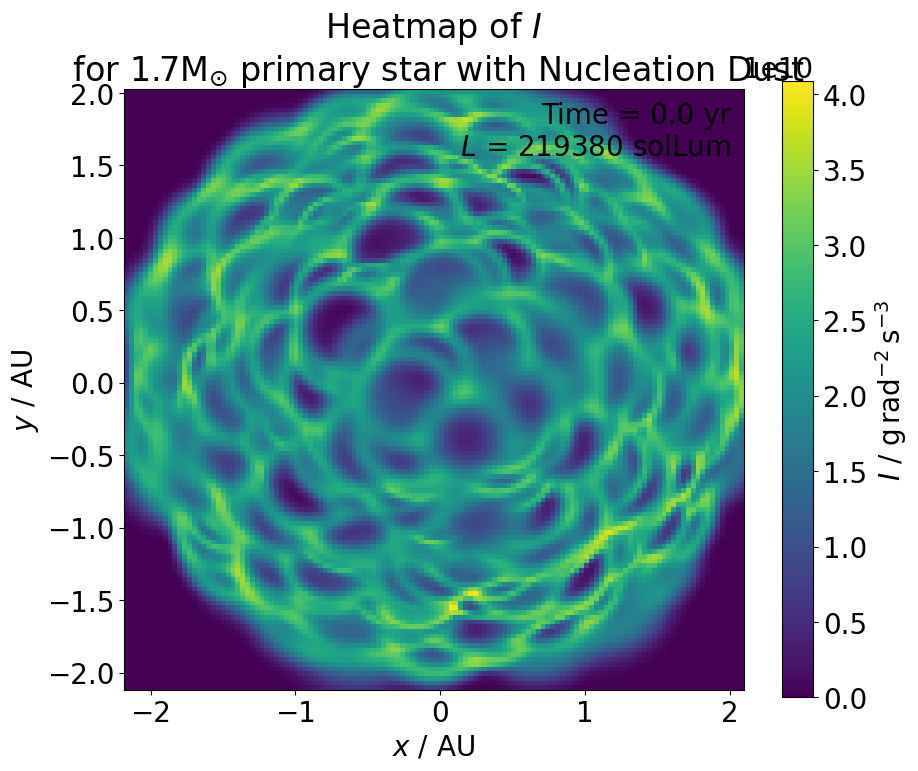

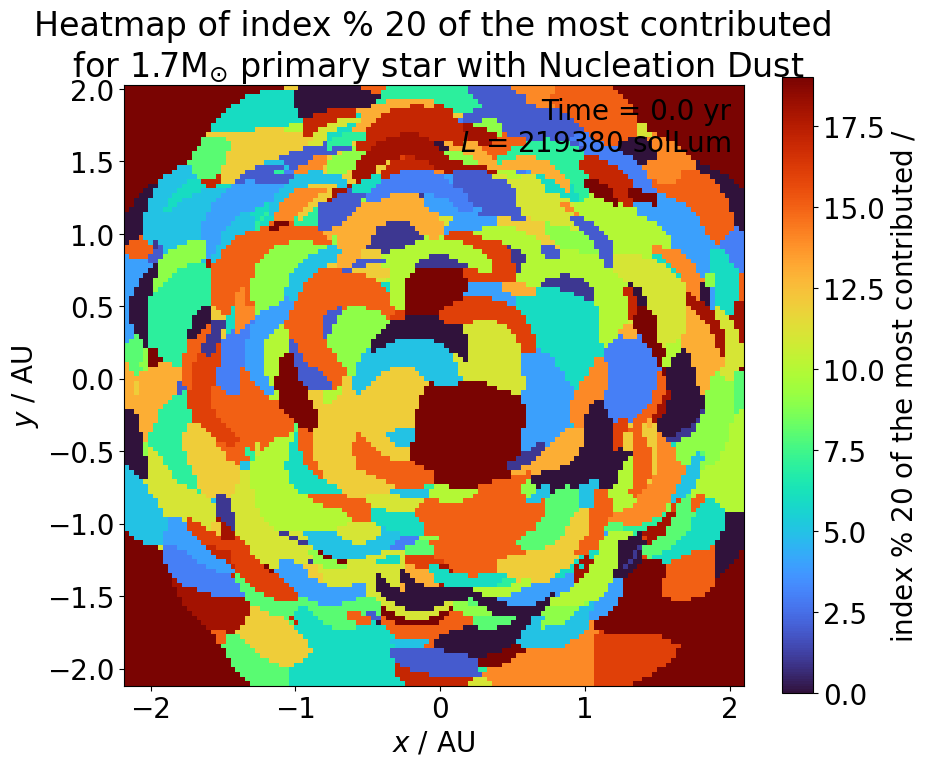

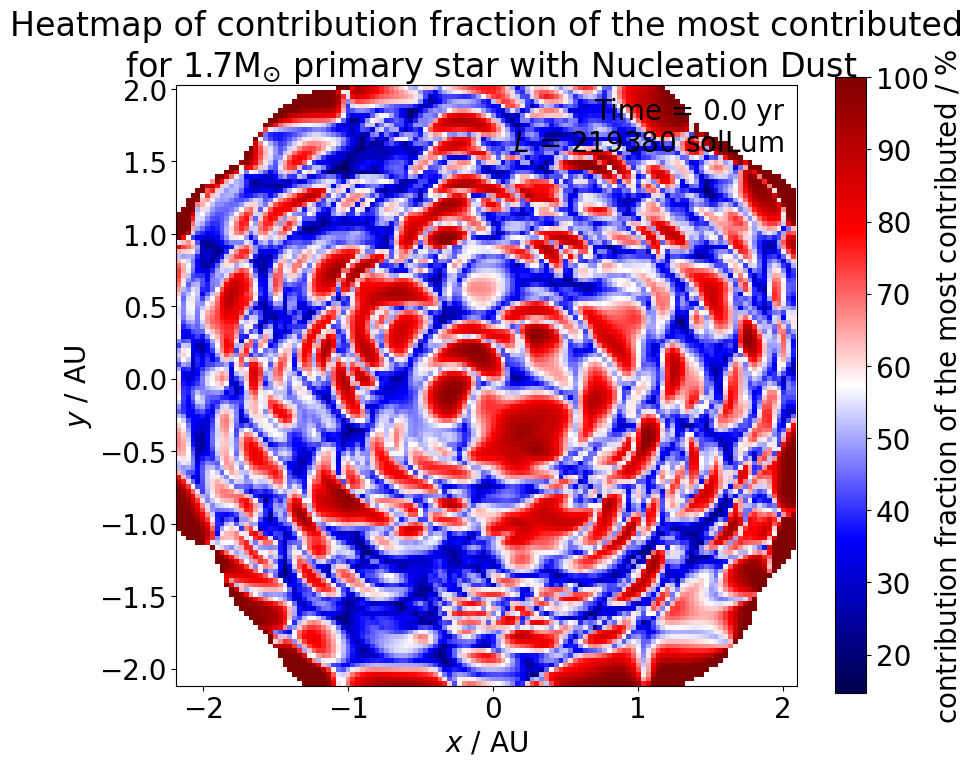

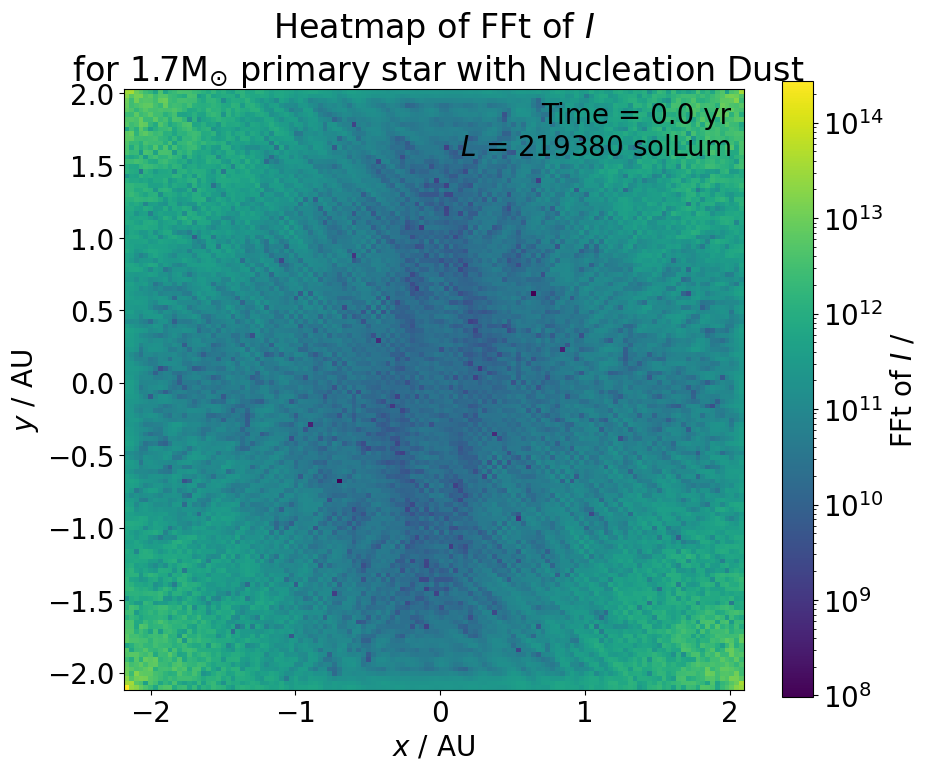

In [43]:
# plotting
plt.close('all')
fig, ax, outfilenames = plot_imshow(
    no_xy, rays_u, rads, data_label="$I$", save_label=f"{xyzs}_I",
    job_profile=job_profile, file_index=file_index, notes=data, output_dir=output_dir)
fig, ax, outfilenames = plot_imshow(
    no_xy, rays_u, inds%20, data_label="index % 20 of the most contributed", save_label=f"{xyzs}_dinds",
    job_profile=job_profile, file_index=file_index, cmap='turbo', notes=data, output_dir=output_dir)
fig, ax, outfilenames = plot_imshow(
    no_xy, rays_u, contr, data_label="contribution fraction of the most contributed", save_label=f"{xyzs}_contr",
    job_profile=job_profile, file_index=file_index, cmap='seismic', notes=data, output_dir=output_dir)
fig, ax, outfilenames = plot_imshow(
    no_xy, rays_u, np.abs(anses_fft), data_label="FFt of $I$", save_label=f"{xyzs}_I-fft",
    norm=mpl.colors.LogNorm(),
    job_profile=job_profile, file_index=file_index, notes=data, output_dir=output_dir)

In [179]:
# do integration
python_time_start = datetime.utcnow()
print(f"Start: {python_time_start.isoformat()}")

ans = integrate_along_ray_gridxy_err_ind(sdf, srcfuncs, rays, xyzs_names_list=xyzs_names_list, verbose=99)
rads, errs = ans
rads = (rads * mpdf.units['sigma_sb'] * mpdf.units['temp']**4 / units.sr).cgs
errs = (errs * mpdf.units['sigma_sb'] * mpdf.units['temp']**4 / units.sr).cgs
lum = ((4 * pi * units.sr) * (rads * areas_u)).sum().to(units.solLum)
lum_err =  ((4 * pi * units.sr) * (errs * areas_u)).sum().to(units.solLum)
print(lum, lum_err)

python_time_ended = datetime.utcnow()
python_time__used  = python_time_ended - python_time_start
print(f"Ended: {python_time_ended.isoformat()}\nTime Used: {python_time__used}")

Start: 2024-03-23T06:39:17.518224
    Debug  :    integrate_along_ray_gridxy_err_ind():
	1807 particles actually participated in calculation (0.13% of all particles, average 0.11 per ray.)


KeyboardInterrupt: 

In [69]:
rays

array([[[-2.26869084e+05, -2.40071403e+05,  0.00000000e+00],
        [-2.26869084e+05, -2.40071403e+05,  1.00000000e+00]],

       [[-2.26869084e+05, -2.36333481e+05,  0.00000000e+00],
        [-2.26869084e+05, -2.36333481e+05,  1.00000000e+00]],

       [[-2.26869084e+05, -2.32595558e+05,  0.00000000e+00],
        [-2.26869084e+05, -2.32595558e+05,  1.00000000e+00]],

       ...,

       [[ 1.56281969e+05,  2.27168935e+05,  0.00000000e+00],
        [ 1.56281969e+05,  2.27168935e+05,  1.00000000e+00]],

       [[ 1.56281969e+05,  2.30906858e+05,  0.00000000e+00],
        [ 1.56281969e+05,  2.30906858e+05,  1.00000000e+00]],

       [[ 1.56281969e+05,  2.34644781e+05,  0.00000000e+00],
        [ 1.56281969e+05,  2.34644781e+05,  1.00000000e+00]]])

### Running all files

    Note: Density column rho already exist in self.time = 0.0.
Start: 2024-03-27T04:39:53.969171
	2md_00000_xyz
    Debug  :    integrate_along_ray_gridxy_err_ind():
	1824 particles actually participated calculation (0.13% of all particles, average 0.11 per ray.)
Ended: 2024-03-27T04:40:12.611588
Time Used: 0:00:18.642417

Start: 2024-03-27T04:40:12.611689
	2md_00000_xzy
    Debug  :    integrate_along_ray_gridxy_err_ind():
	1835 particles actually participated calculation (0.13% of all particles, average 0.11 per ray.)
Ended: 2024-03-27T04:40:37.199845
Time Used: 0:00:24.588156

    Note: Density column rho already exist in self.time = 20000.0.
Start: 2024-03-27T04:40:39.199840
	2md_00400_xyz
    Debug  :    integrate_along_ray_gridxy_err_ind():
	6682 particles actually participated calculation (0.48% of all particles, average 0.4 per ray.)
Ended: 2024-03-27T04:41:12.766280
Time Used: 0:00:33.566440

Start: 2024-03-27T04:41:12.766393
	2md_00400_xzy
    Debug  :    integrate_along_ray_

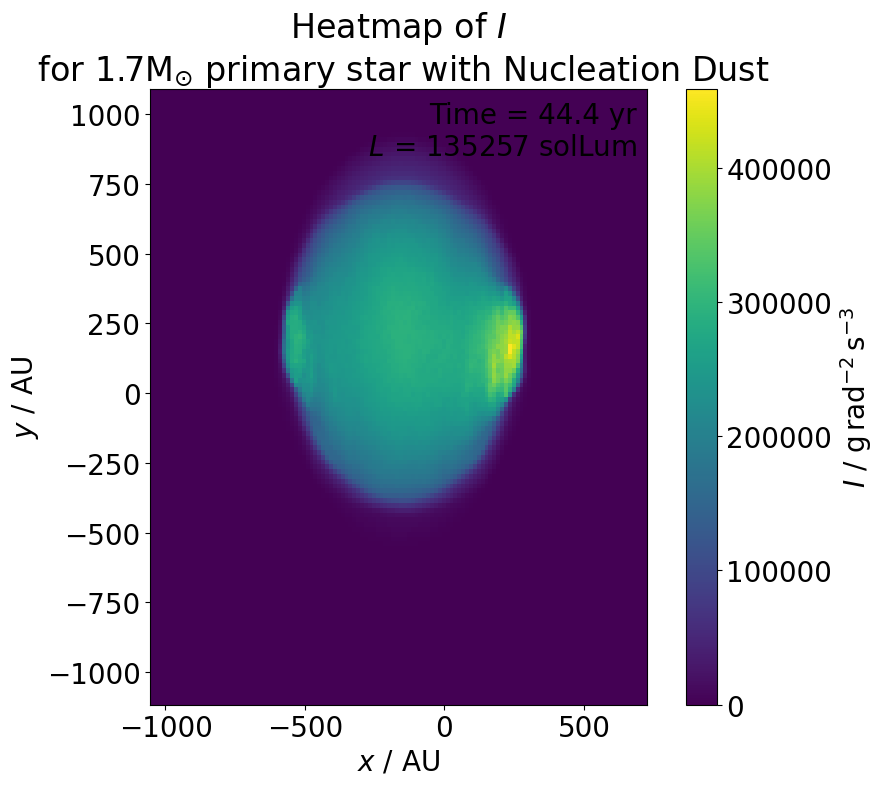

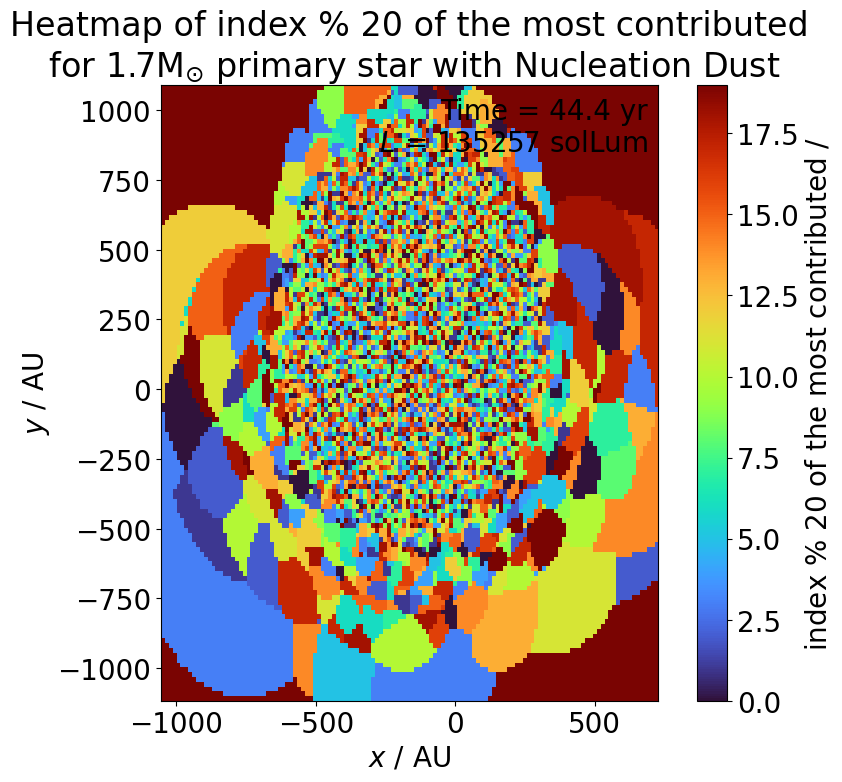

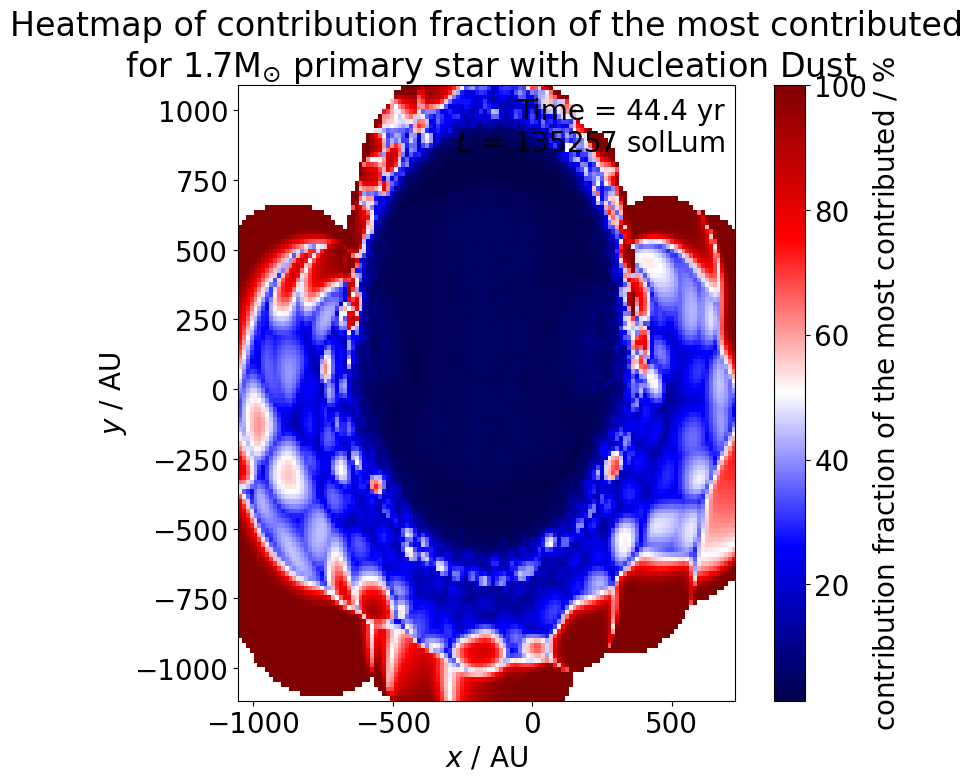

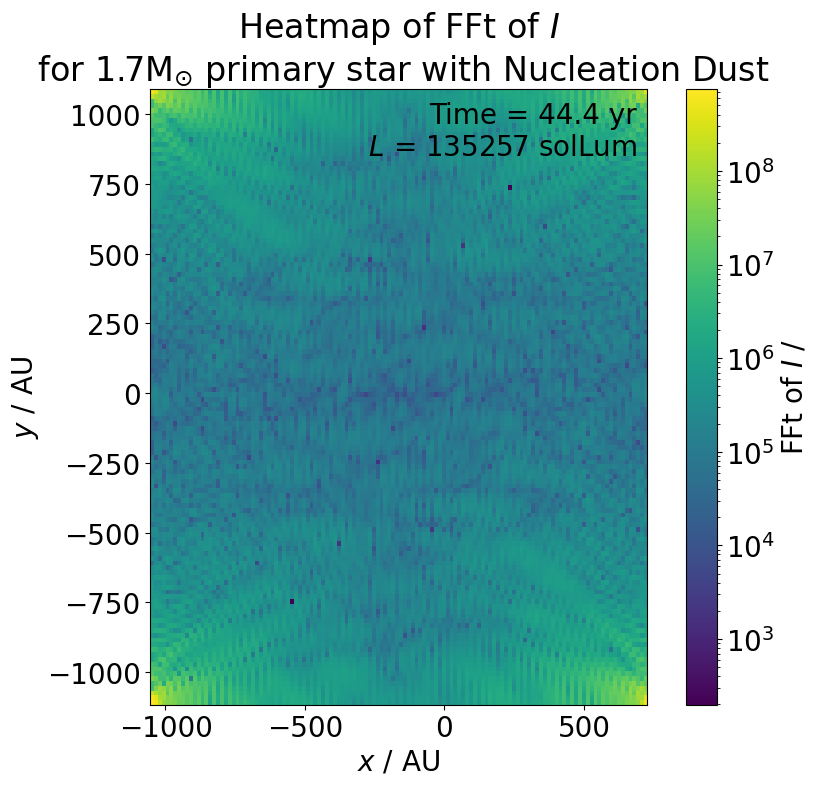

In [53]:
# inputs
output_dir = '../fig/20240222_LCGen/'
file_indexes = np.array([0, 400, 800, 1200, 1600, 2000, 4800, 6400, 8000, 17600])
xyzs_list  = ['xyz', 'xzy']
#job_nickname= '2md'
#file_index  = 0
#xyzs = 'xyz'
no_xy=(128, 128)
verbose_loop = 0

no_xy_txt = 'x'.join([f'{i}' for i in no_xy])
# init combined data
comb = {}

for job_nickname in ['2md',]: #['2md', '4md']:
    comb[job_nickname] = {
        xyzs: {
            'times_yr' : [],
            'lums_Lsun': [],
            } for xyzs in xyzs_list
        }
        
    for file_index in file_indexes:
        # init
        job_profile = JOB_PROFILES_DICT[job_nickname]
        job_name    = job_profile['job_name']
        params      = job_profile['params']
        eos_opacity = EoS_MESA_opacity(params, settings)
        mpdf = mpdf_read(job_name, file_index, eos_opacity, reset_xyz_by='R1', verbose=1)
        mpdf.calc_sdf_params(['R1'])
        sdf  = mpdf.data['gas']
        srcfuncs = mpdf.const['sigma_sb'] * sdf['T']**4 / pi
        sdf['srcfunc'] = srcfuncs
        for xyzs in xyzs_list:
            xyzs_names_list = [x for x in xyzs]

            
            # record time used
            python_time_start = datetime.utcnow()
            print(f"Start: {python_time_start.isoformat()}")
            print(f"\t{job_nickname}_{file_index:05d}_{xyzs}")

            
            # get rays
            rays, areas, dXs = get_xy_grids_of_rays(
                sdf, no_xy=no_xy, frac_contained=100., use_adaptive_grid=False, xyzs_names_list=xyzs_names_list)
            pts    = np.array(sdf[xyzs_names_list])
            hs     = np.array(sdf[ 'h' ])    # npart-shaped array
            kernel = sdf.kernel
            kernel_rad = float(kernel.get_radius())
            col_kernel = kernel.get_column_kernel_func(samples=1000)
            
            rays_u = (rays * mpdf.units['dist']).to(units.au)
            areas_u = (areas * mpdf.units['dist']**2).to(units.au**2)

            
            # do integration without error estimation
            ans = integrate_along_ray_gridxy_ind(sdf, srcfuncs, rays, xyzs_names_list=xyzs_names_list, verbose=99)
            rads, inds, contr, pts_order_used = ans
            rads = (rads * mpdf.units['sigma_sb'] * mpdf.units['temp']**4 / units.sr).cgs
            inds *= units.dimensionless_unscaled
            contr = 100 * contr * units.percent
            lum = ((4 * pi * units.sr) * (rads * areas_u)).sum().to(units.solLum)
            anses_fft = fft.fft2(rads.reshape(no_xy).value)
        
            # save interm data
            data = {}
            data['lum'  ] = lum
            data['rays' ] = rays_u[:, 0, :2]
            data['ray_unit_vec'] = get_ray_unit_vec(rays_u[0].value)
            data['area_per_ray'] = areas_u[0] #areas_u
            data['rads' ] = rads
            data['time' ] = mpdf.get_time()
            data['mpdf_params'] = mpdf.params
            
            with open(f"{interm_dir}{job_nickname}_{file_index:05d}.lcgen.{xyzs}.{no_xy_txt}.json", 'w') as f:
                mupl.json_dump(data, f, metadata)

            comb[job_nickname][xyzs]['times_yr' ].append(data['time'].to_value(units.yr))
            comb[job_nickname][xyzs]['lums_Lsun'].append(data['lum' ].to_value(units.Lsun))

            
            # plotting
            plt.close('all')
            fig, ax, outfilenames = plot_imshow(
                no_xy, rays_u, rads, data_label="$I$", save_label=f"{xyzs}_I",
                job_profile=job_profile, file_index=file_index, notes=data, output_dir=output_dir, verbose=verbose_loop)
            fig, ax, outfilenames = plot_imshow(
                no_xy, rays_u, inds%20, data_label="index % 20 of the most contributed", save_label=f"{xyzs}_dinds",
                job_profile=job_profile, file_index=file_index, cmap='turbo', notes=data, output_dir=output_dir, verbose=verbose_loop)
            fig, ax, outfilenames = plot_imshow(
                no_xy, rays_u, contr, data_label="contribution fraction of the most contributed", save_label=f"{xyzs}_contr",
                job_profile=job_profile, file_index=file_index, cmap='seismic', notes=data, output_dir=output_dir, verbose=verbose_loop)
            fig, ax, outfilenames = plot_imshow(
                no_xy, rays_u, np.abs(anses_fft), data_label="FFt of $I$", save_label=f"{xyzs}_I-fft",
                norm=mpl.colors.LogNorm(),
                job_profile=job_profile, file_index=file_index, notes=data, output_dir=output_dir, verbose=verbose_loop)


            # record time used
            python_time_ended = datetime.utcnow()
            python_time__used  = python_time_ended - python_time_start
            print(f"Ended: {python_time_ended.isoformat()}\nTime Used: {python_time__used}\n")
            

plt.close('all')
with open(f"{interm_dir}lcgen.{no_xy_txt}.json", 'w') as f:
    mupl.json_dump(comb, f, metadata)

*   Note   :    run_ast_nodes::run_code::<module>():
	Fig saved to ../fig/20240222_LCGen/LC_2md_128x128.png.
*   Note   :    run_ast_nodes::run_code::<module>():
	Fig saved to ../fig/20240222_LCGen/LC_2md_128x128.pdf.


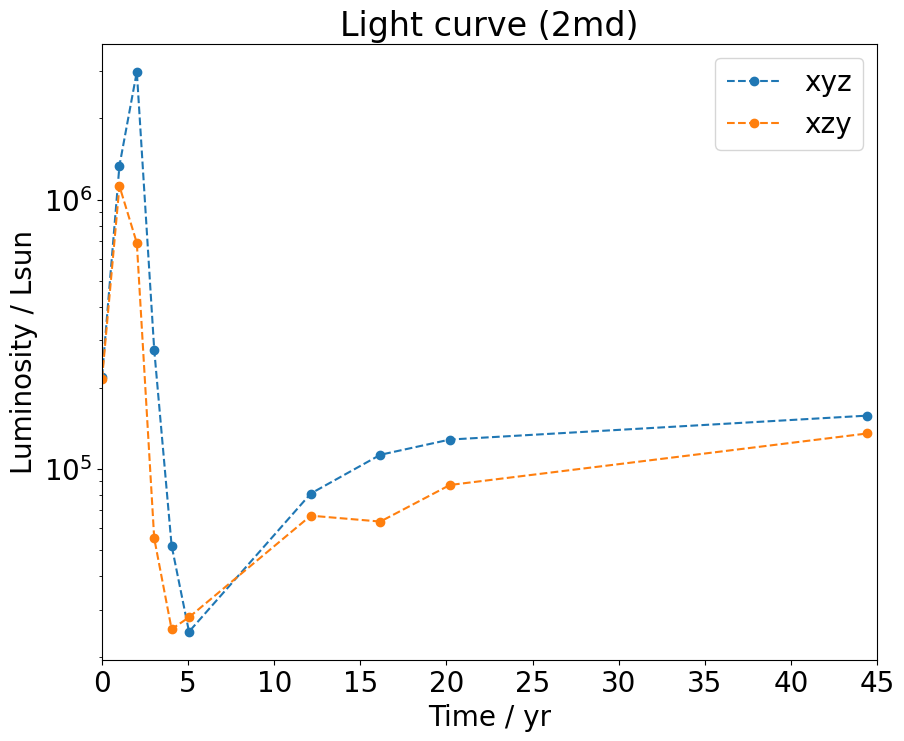

In [74]:
job_nickname='2md'
fig, ax = plt.subplots(figsize=(10, 8))
for xyzs in xyzs_list:
    ax.semilogy(comb[job_nickname][xyzs]['times_yr'], comb[job_nickname][xyzs]['lums_Lsun'], 'o--', label=xyzs)
ax.legend()
ax.set_xlabel('Time / yr')
ax.set_ylabel('Luminosity / Lsun')
ax.set_title(f"Light curve ({job_nickname})")
ax.set_xlim(0., 45.)
for ext in ['png', 'pdf']:
    outfilename = (
        f"{output_dir}LC_{job_profile['nickname']}_{no_xy_txt}.{ext}")
    fig.savefig(outfilename)
    if is_verbose(verbose, 'note'):
        say('note', None, verbose, f"Fig saved to {outfilename}.")

### Timeit

**  Warning:    integrate_along_ray_grid():
	This function is a work in progress-
	It is highly likely to be removed and integrated into integrate_along_ray_grid() in the future,and even if not, the input & output format may still change in the future,
	especially to output uncertainty estimation as well!


array([0., 0., 0., ..., 0., 0., 0.])

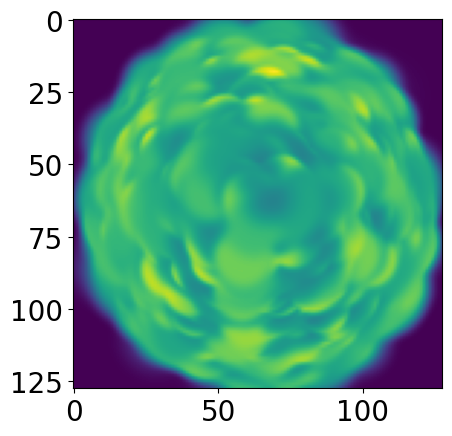

In [16]:
xyzs = 'yzx'
xyzs_names_list = [x for x in xyzs]
ans = integrate_along_ray_gridxy(sdf, srcfuncs, rays, xyzs_names_list=xyzs_names_list)
plt.close('all')
plt.imshow(ans.reshape(no_xy))
plt.savefig(f"{output_dir}/heat_I_{job_nickname}_{mpdf.file_index}_{xyzs}.png")
ans

In [50]:
%timeit integrate_along_ray_grid(sdf, srcfuncs, rays, verbose=0)

3.8 s ± 391 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [79]:
%timeit integrate_along_ray_gridxy(sdf, srcfuncs, rays, verbose=0)

38.6 s ± 1.76 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%timeit [integrate_along_ray(sdf, ray, srcfuncs)[4] for ray in rays]

3.46 s ± 52.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Analyzing error for tau

In [112]:
# integrating for column kernel
kernel = sdf.kernel
ndim   = 3
q_xy   = 1.
w_col  = kernel.get_column_kernel_func(1000)

q_xy   = 0.

@jit(nopython=True, fastmath=True)
def get_q(*q_is):
    ans = 0
    for q_i in q_is:
        ans += q_i**2
    return ans**0.5


def get_w_q(q_z, q_xy, w, ndim):
    return kernel.w(get_q(q_xy, q_z), ndim)

def my_col(q_xy:float, kernel, ndim:int = 3):
    w = kernel.w
    w_rad = kernel.get_radius()
    return integrate.quad(lambda q_z: w(get_q(q_xy, q_z), ndim), -w_rad, w_rad)
    
my_col(q_xy, kernel=kernel, ndim=ndim),  w_col(q_xy, ndim)

((0.477464829275686, 5.304133868233585e-15), 0.4774648292758465)

In [196]:


def get_tau_for_single_particle(kappa_m_div_h2:float, q_xy:float, kernel, ndim:int = 3):
    w = kernel.w
    w_rad = kernel.get_radius()
    w_col = kernel.get_column_kernel_func(1000)

    return -np.log(integrate.quad(
        lambda q_z: np.exp(-kappa_m_div_h2 * integrate.quad(
            lambda q_z1: w(get_q(q_xy, q_z1), ndim),
            -w_rad, q_z
        )[0]) * w(get_q(q_xy, q_z), ndim),
        -w_rad, w_rad, 
    )[0] / w_col(q_xy, ndim))

kappa_m_div_h2, q_xy = 10., 0.1
dtau  = kappa_m_div_h2*w_col(q_xy, ndim)
w_col = kernel.get_column_kernel_func(1000)
term = 1-np.exp(-dtau)
tau = get_tau_for_single_particle(kappa_m_div_h2=kappa_m_div_h2, q_xy=q_xy, kernel=kernel, ndim=ndim)
print(f"{tau=}", f"{dtau=}", f"frac= {(tau/dtau)*100:.2f}%", '', sep='\n')
print(f"{np.exp(-tau    )*term=}",  f"{np.exp(-0.     )*term=}", f"{np.exp(-dtau/2.)*term=}", f"{np.exp(-dtau   )*term=}", sep='\n')

tau=1.558565820992827
dtau=4.709175154891225
frac= 33.10%

np.exp(-tau    )*term=0.20854115215226074
np.exp(-0.     )*term=0.9909877918066887
np.exp(-dtau/2.)*term=0.09407709801481419
np.exp(-dtau   )*term=0.00893098829679167


In [192]:
w_col

CPUDispatcher(<function BaseKernel.get_column_kernel_func.<locals>.func at 0x146fe5034e00>)

In [191]:
kappa_m_div_h2 * integrate.quad(
            lambda q_z1: w(get_q(q_xy, q_z1), ndim),
            -2., 1.)[0]

0.045134625081233753

In [70]:
help(kernel.get_column_kernel_func)

Help on method get_column_kernel_func in module sarracen.kernels.base_kernel:

get_column_kernel_func(samples) method of sarracen.kernels.cubic_spline.CubicSplineKernel instance
    Generate a numba-accelerated column kernel function.
    
    Creates a numba-accelerated function for column kernel weights. This function
    can be utilized similarly to kernel.w.
    
    Parameters
    ----------
    samples: int
        Number of sample points to calculate when approximating the kernel.
    
    Returns
    -------
    A numba-accelerated weight function.



### In Writing

#### Getting LC

In [9]:
do_extrap : bool = False
T_cond_oxy: units.Quantity = 1450 * units.K
kappa_gas : units.Quantity = 2e-4*(units.cm**2/units.g)
job_name    = '../dustystar/clmu_dustybase/relax'#job_profile['job_name']
file_index  = 0
params      = JOB_PROFILES_DICT['2md']['params'] #job_profile['params']


mpdf = mupl.MyPhantomDataFrames()
mpdf.read(job_name, file_index, reset_xyz_by='CoM', calc_params=['vr', 'R1'], verbose=verbose)
sdf  = mpdf.data['gas']
eos = mupl.get_eos(ieos=10, params=params, settings=settings)
eos_opacity = EoS_MESA_opacity(params, settings)
sdf['T'] = eos.get_temp(rho=mpdf.get_val('rho'), u=mpdf.get_val('u')).to_value(mpdf.units['temp'])
del sdf['Tdust']
kappa_mesa = eos_opacity.get_kappa(mpdf.get_val('rho'), mpdf.get_val('T'), do_extrap=do_extrap)
#mpdf.data['gas']['kappa'] = np.where(
#    mpdf.data['gas']['T'] < T_cond_oxy,
#    kappa_gas.to_value( mpdf.units['opacity']),
#    kappa_mesa.to_value(mpdf.units['opacity']),
#)
mpdf.data['gas']['kappa'] = kappa_mesa.to_value(mpdf.units['opacity'])

*   Note   :    MyPhantomDataFrames.read():
	

	Reading filename='../dustystar/clmu_dustybase/relax_00000'


*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	Reseting Origin to CoM ([-3.80369850e-16  3.71216564e-17 -6.51535922e-19])...
*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	CoM location is now [-2.44519036e-16  2.48560465e-17 -4.36257665e-19]


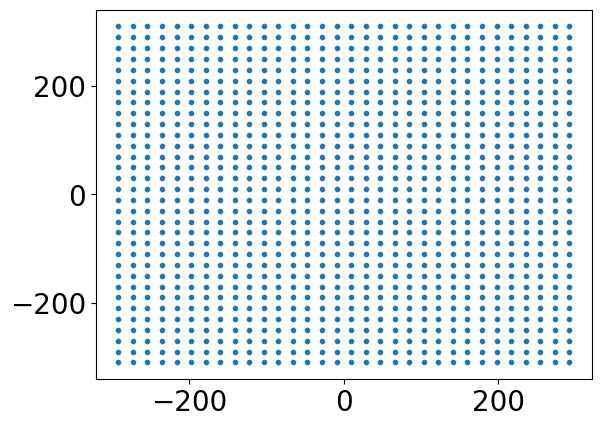

In [17]:
# testing ray loc distribution
rays, areas, dXs = get_xy_grids_of_rays(sdf, no_xy=(32, 32), frac_contained=100., use_adaptive_grid=False)
plt.plot(rays[:, 0, 0], rays[:, 0, 1], '.')

In [19]:
hs = dats
hs

array([0., 0., 0., ..., 0., 0., 0.])

In [20]:
#no_xy=(17, 17)
no_xy=(32, 32)
srcfuncs = np.array(mpdf.const['sigma_sb'] * sdf['T']**4) / pi #/ (4 * pi)
#srcfuncs = np.array(sdf['h'])


rays, areas, _ = get_xy_grids_of_rays(sdf, no_xy=no_xy, frac_contained=100., use_adaptive_grid=False)
dats = integrate_along_ray_grid(sdf, srcfuncs, rays, verbose=0)
lums = (4 * pi * dats * areas * mpdf.units['lum']).to(units.solLum)
lum  = lums.sum()
print(f"{lum:.2e}")
lum

3.11e+04 solLum


<Quantity 31063.67752247 solLum>

(array([ 118.,  296., 3210., 3684., 1236.,  842.,  346.,  124.,  100.,
          44.]),
 array([3.33697822, 3.60437679, 3.87177536, 4.13917393, 4.4065725 ,
        4.67397107, 4.94136964, 5.20876821, 5.47616678, 5.74356535,
        6.01096392]),
 <BarContainer object of 10 artists>)

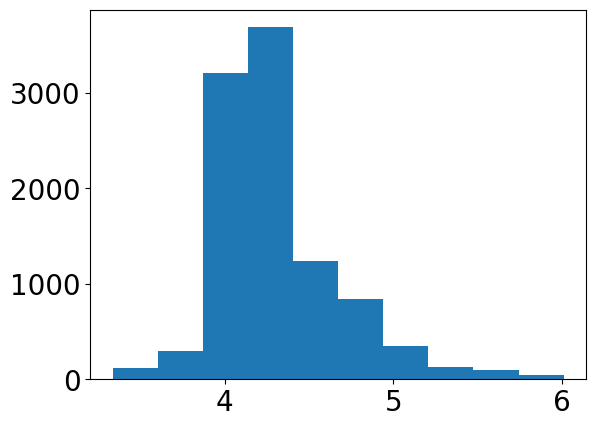

In [367]:
plt.hist(np.log10(mpdf.get_val('T').value))

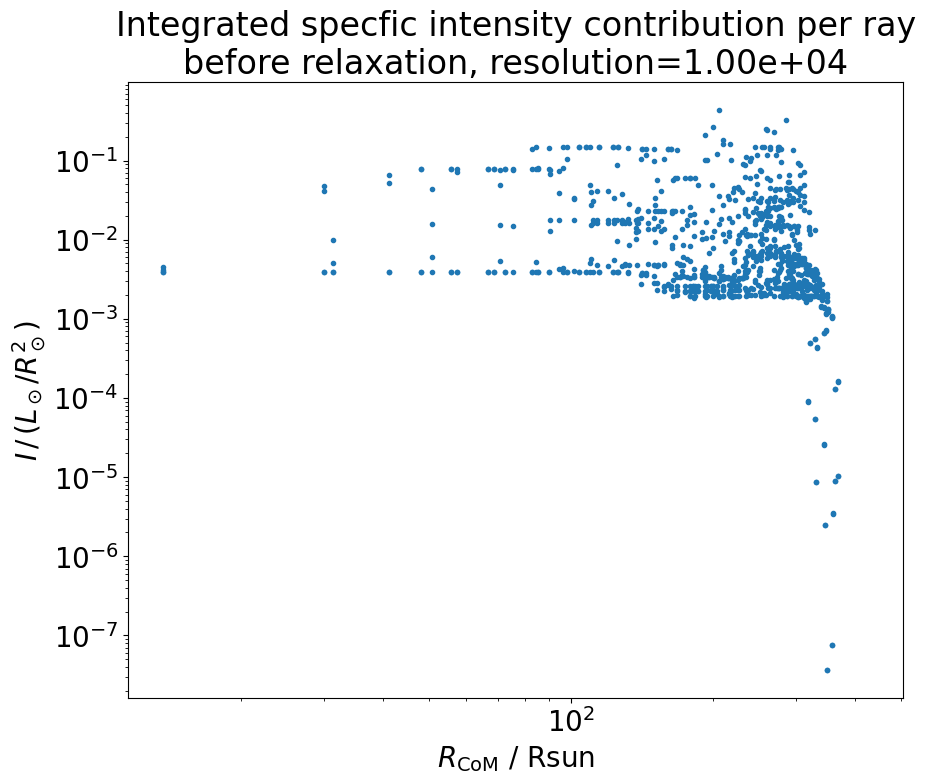

In [26]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.loglog(np.sqrt(rays[:, 0, 0]**2+rays[:, 0, 1]**2), lums.to_value(units.Lsun) / areas, '.')
ax.set_xlabel('$R_\\mathrm{CoM}$ / Rsun')
ax.set_ylabel('$I \\, / \\, (4 \pi L_\\odot / R_\\odot^2)$')
#ax.set_ylabel('$\\triangle L$ / Lsun')
ax.set_title(f"Integrated specfic intensity contribution per ray\nbefore relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/scatter_dlum-vs-RCoM_relax_res{mpdf.params['nparttot']:.2e}.png")

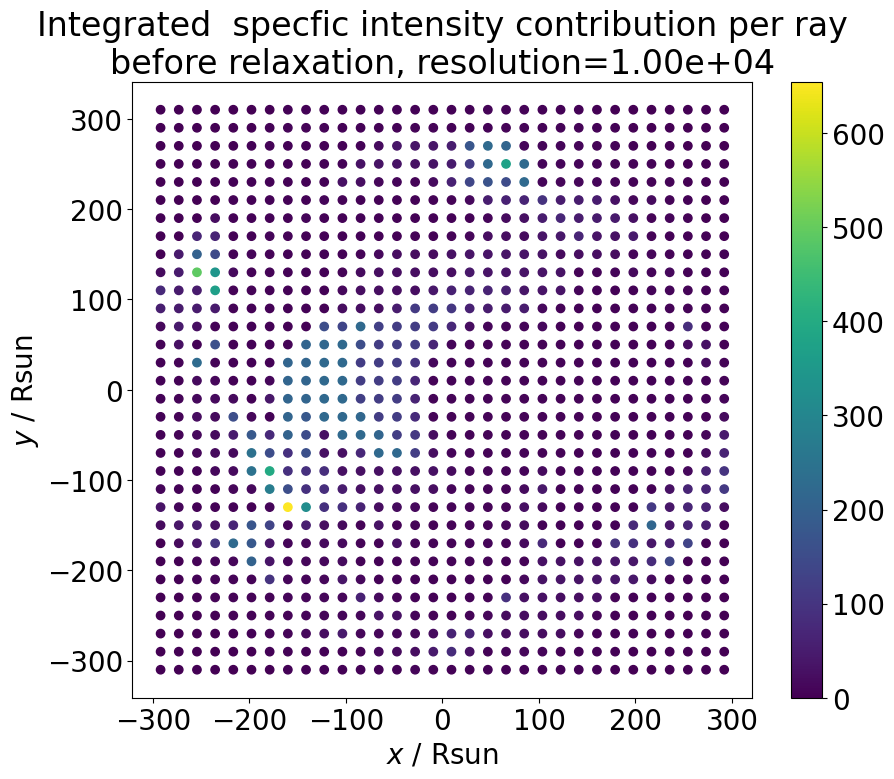

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))
s = ax.scatter(rays[:, 0, 0], rays[:, 0, 1], c=np.array(lums).reshape(no_xy))
fig.colorbar(s, label='')# {I / (4 \pi L_\\odot / R_\\odot^2)}$')
ax.set_xlabel('$x$ / Rsun')
ax.set_ylabel('$y$ / Rsun')
ax.set_title(f"Integrated  specfic intensity contribution per ray\nbefore relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/heat_dlum_relax_res{mpdf.params['nparttot']:.2e}.png")

.

#### Trying the same thing with after-relaxed higher resolution model

.

In [23]:
job_nickname= '2md'
job_profile = JOB_PROFILES_DICT[job_nickname]
job_name    = job_profile['job_name']
params      = job_profile['params']
eos_opacity = EoS_MESA_opacity(params, settings)
mpdf = mpdf_read(job_name, 0, eos_opacity, reset_xyz_by='R1')
mpdf.calc_sdf_params(['R1'])
sdf  = mpdf.data['gas']
print(f"{mpdf.get_time() = }")

*   Note   :    MyPhantomDataFrames.read():
	

	Reading filename='../photosphere/luis_2md/light_00000'


*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	Reseting Origin to R1 ([-1.43135206e+02  6.48807731e-03  5.43625638e-03])...
*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	CoM location is now [ 1.43135206e+02 -6.48807731e-03 -5.43625638e-03]
**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])
    Note: Density column rho already exist in self.time = 0.0.
mpdf.get_time() = <Quantity 0. yr>


In [29]:
mpdf.data['gas']['T'] = eos.get_temp(rho=mpdf.get_val('rho'), u=mpdf.get_val('u')).to_value(mpdf.units['temp'])
mpdf.data['gas'][['Tdust', 'temperature', 'T']]

,Tdust,temperature,T
0,905.561625,905.561625,905.129634
1,1115.608310,1115.608310,1115.695717
2,646.971790,646.971790,647.096207
3,558.378969,558.378969,558.402400
4,1069.234617,1069.234617,1069.029598
...,...,...,...
1372083,391.453956,391.453956,391.395060
1372084,793.322333,793.322333,793.402575
1372085,890.293809,890.293809,890.389795
1372086,1044.076902,1044.076902,1044.605001


In [24]:
#no_xy=(17, 17)
no_xy=(32, 32)

srcfuncs = np.array(mpdf.const['sigma_sb'] * sdf['T']**4) / pi
rays, areas, _ = get_xy_grids_of_rays(sdf, no_xy=no_xy, frac_contained=100., use_adaptive_grid=False)
dats = integrate_along_ray_grid(sdf, srcfuncs, rays, verbose=0)
lums = (4 * pi * dats * areas * mpdf.units['lum']).to(units.solLum)
lum  = lums.sum()
print(f"{lum:.2e}")
lum

4.37e+05 solLum


<Quantity 436826.62309983 solLum>

In [26]:
srcfuncs = np.array(sdf['h'])
rays, areas, _ = get_xy_grids_of_rays(sdf, no_xy=no_xy, frac_contained=100., use_adaptive_grid=False)
hs   = integrate_along_ray_grid(sdf, srcfuncs, rays, verbose=0)
hs  *= units.Rsun
hs

<Quantity [0., 0., 0., ..., 0., 0., 0.] solRad>

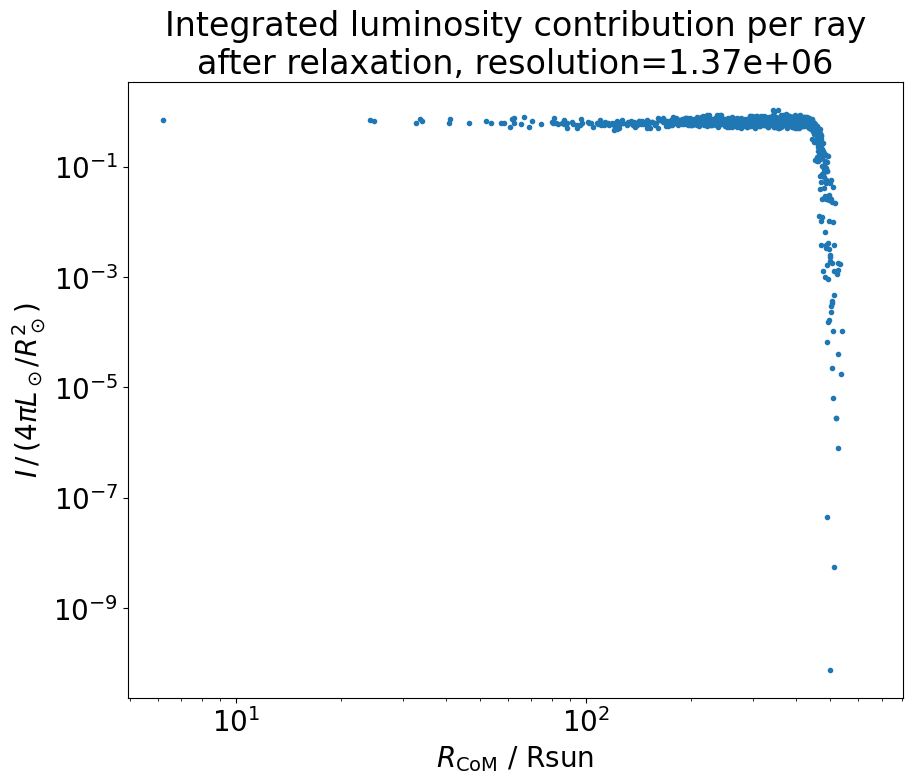

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.loglog(np.sqrt(rays[:, 0, 0]**2+rays[:, 0, 1]**2), lums.value / areas, '.')
ax.set_xlabel('$R_\\mathrm{CoM}$ / Rsun')
ax.set_ylabel('$I \\, / \\, (4 \pi L_\\odot / R_\\odot^2)$')
ax.set_title(f"Integrated luminosity contribution per ray\nafter relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/scatter_dlum-vs-RCoM_light_res{mpdf.params['nparttot']:.2e}.png")

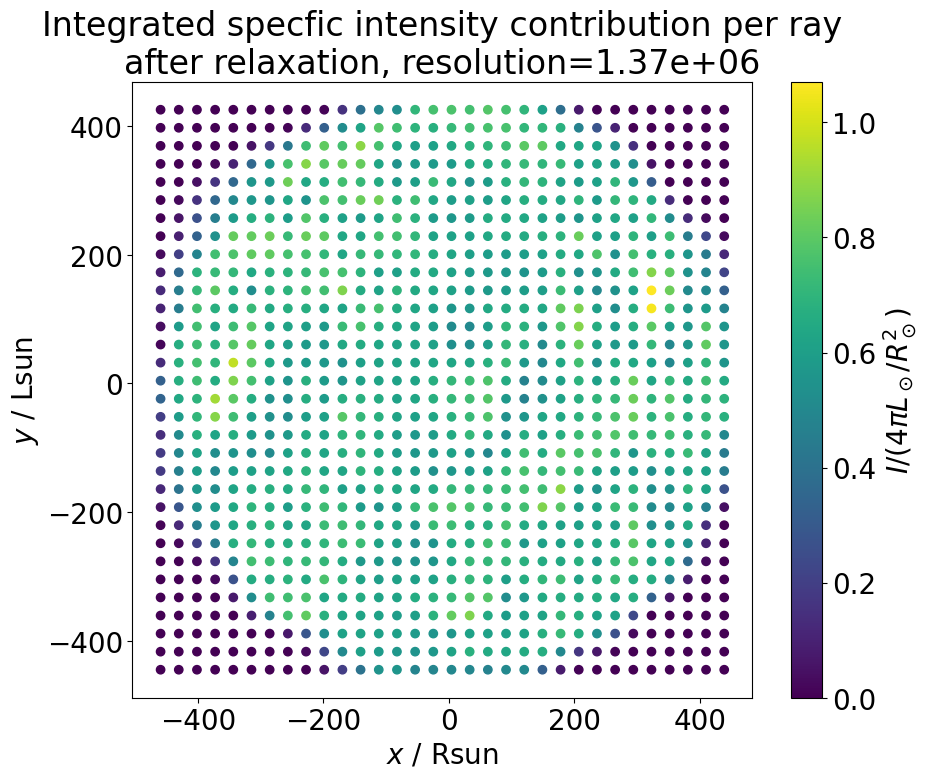

In [34]:
fig, ax = plt.subplots(figsize=(10, 8))
s = ax.scatter(rays[:, 0, 0], rays[:, 0, 1], c=(np.array(lums / areas).reshape(no_xy))) #np.log10
fig.colorbar(s, label='${I / (4 \pi L_\\odot / R_\\odot^2)}$') #\\log_{10} 
ax.set_xlabel('$x$ / Rsun')
ax.set_ylabel('$y$ / Lsun')
ax.set_title(f"Integrated specfic intensity contribution per ray\nafter relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/heat_dI_light_res{mpdf.params['nparttot']:.2e}.png")

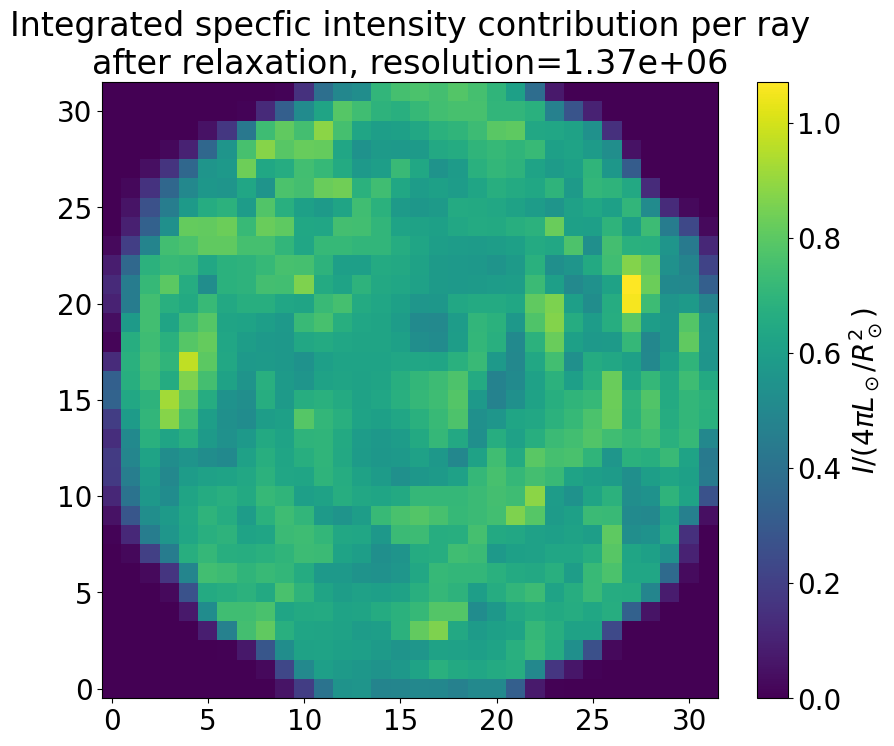

In [46]:
fig, ax = plt.subplots(figsize=(10, 8))
#s = ax.scatter(rays[:, 0, 0], rays[:, 0, 1], c=(np.array(lums / areas).reshape(no_xy))) #np.log10
s = ax.imshow(np.array(lums / areas).reshape(no_xy), origin='lower')
fig.colorbar(s, label='${I / (4 \pi L_\\odot / R_\\odot^2)}$') #\\log_{10} 
#ax.set_xlabel('$x$')# / Rsun')
#ax.set_ylabel('$y$')# / Lsun')
ax.set_title(f"Integrated specfic intensity contribution per ray\nafter relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/heat_dI_light_res{mpdf.params['nparttot']:.2e}.png")

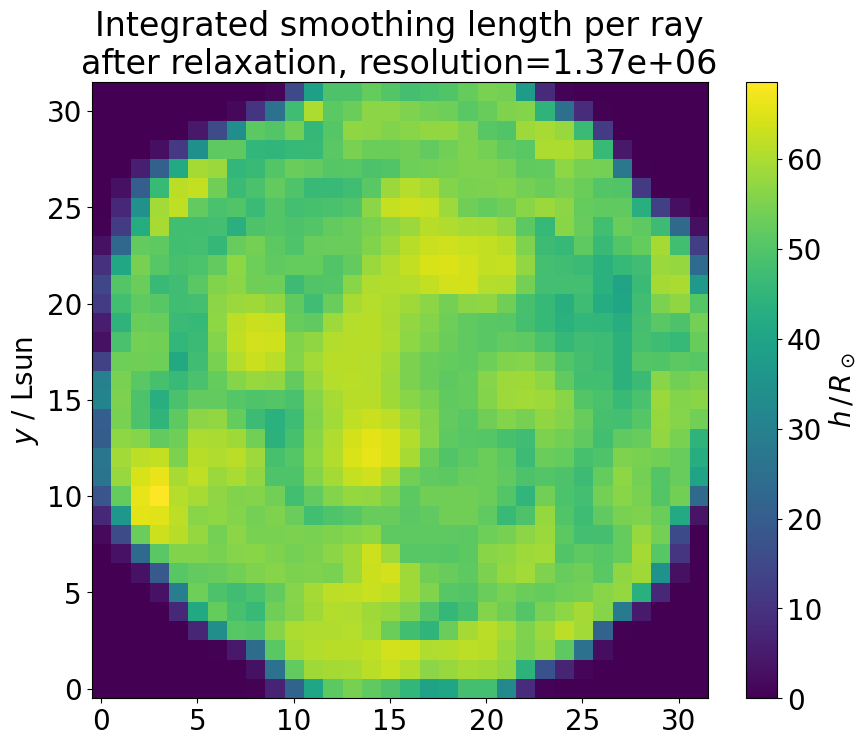

In [49]:
plt.close('all')
fig, ax = plt.subplots(figsize=(10, 8))
#s = ax.scatter(rays[:, 0, 0], rays[:, 0, 1], c=(np.array(lums / areas).reshape(no_xy))) #np.log10
s = ax.imshow(np.array(hs).reshape(no_xy), origin='lower')
fig.colorbar(s, label='$h \\, / \\, R_\\odot$') #\\log_{10} 
#ax.set_xlabel('$x$ / Rsun')
#ax.set_ylabel('$y$ / Lsun')
ax.set_title(f"Integrated smoothing length per ray\nafter relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/heat_h_light_res{mpdf.params['nparttot']:.2e}.png")

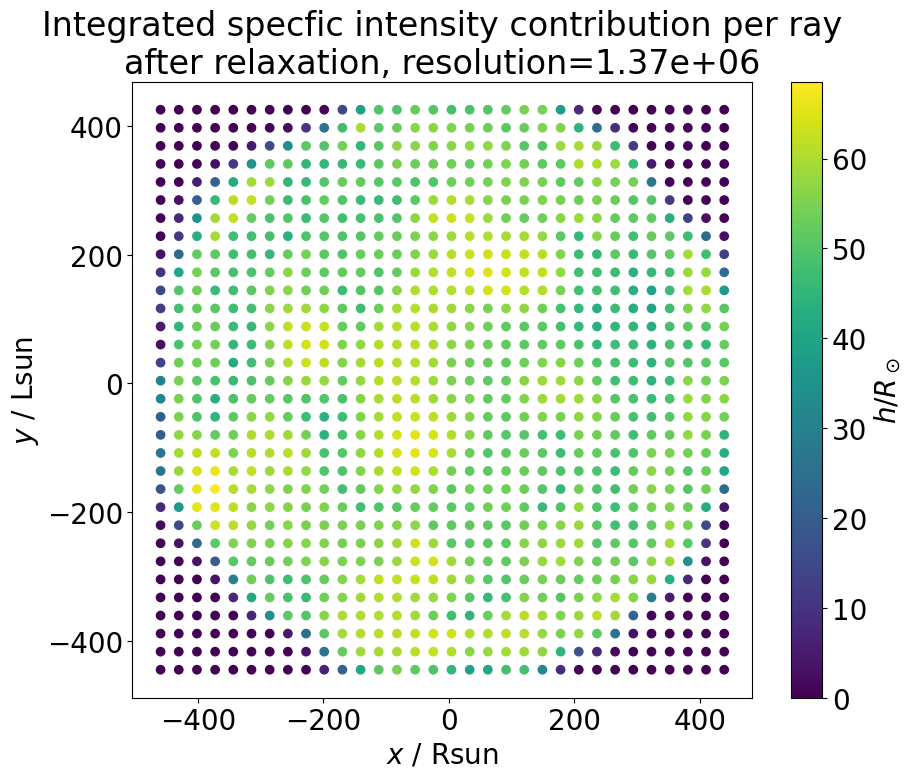

In [33]:
fig, ax = plt.subplots(figsize=(10, 8))
s = ax.scatter(rays[:, 0, 0], rays[:, 0, 1], c=(np.array(hs).reshape(no_xy))) #np.log10
fig.colorbar(s, label='${h / R_\\odot}$') #\\log_{10} 
ax.set_xlabel('$x$ / Rsun')
ax.set_ylabel('$y$ / Lsun')
ax.set_title(f"Integrated specfic intensity contribution per ray\nafter relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/heat_h_light_res{mpdf.params['nparttot']:.2e}.png")

In [40]:
help(ax.imshow)

Help on method imshow in module matplotlib.axes._axes:

imshow(X, cmap=None, norm=None, *, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs) method of matplotlib.axes._axes.Axes instance
    Display data as an image, i.e., on a 2D regular raster.
    
    The input may either be actual RGB(A) data, or 2D scalar data, which
    will be rendered as a pseudocolor image. For displaying a grayscale
    image, set up the colormapping using the parameters
    ``cmap='gray', vmin=0, vmax=255``.
    
    The number of pixels used to render an image is set by the Axes size
    and the figure *dpi*. This can lead to aliasing artifacts when
    the image is resampled, because the displayed image size will usually
    not match the size of *X* (see
    :doc:`/gallery/images_contours_and_fields/image_antialiasing`).
    The resampling can be controlled vi

In [53]:
7534.8/10246.54

0.7353506647121857

In [ ]:
f"{lum:.2e}"

In [83]:
get_xy_grids_of_rays

<function __main__.get_xy_grids_of_rays(sdf: None | sarracen.sarracen_dataframe.SarracenDataFrame = None, dxs: None | tuple[float, float] = (None, None), no_xy: tuple[int, int] = (33, 33), orig_vec: numpy.ndarray = array([0., 0., 0.]), frac_contained: float = 99.73, verbose: int = 3) -> tuple[numpy.ndarray, numpy.ndarray]>

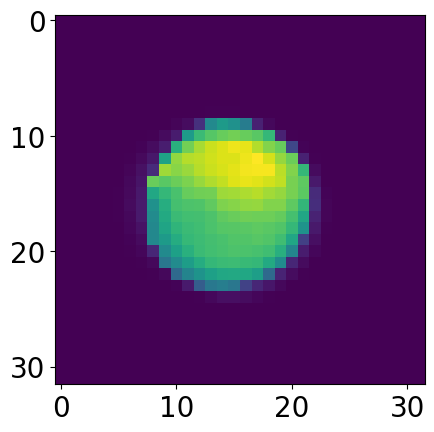

In [38]:
plt.imshow(np.array(lums).reshape(no_xy))

In [136]:
np.max(mpdf.data['gas']['h'])

93.82694

In [15]:
mpdf.data['gas']['u']

0       0.003596
1       0.003596
2       0.012142
3       0.012142
4       0.004077
          ...   
9995    0.003971
9996    0.004889
9997    0.004889
9998    0.008964
9999    0.008964
Name: u, Length: 10000, dtype: float64

## IGNORE BELOW
#### NOT YET FINISHED ADAPTING FROM THE OLD SCRIPTS

### Getting initial MESA profile vs relaxed phantom profile

In [129]:
def plot_stuff(stuff_dict: dict, x_name: str, y_name: str, mpdf, job_profile, xlim: tuple[float, float]=(1., 1.e3)):
    plt.close()
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.loglog(stuff_dict[x_name], stuff_dict[y_name], '.')
    ax.set_xlabel(f"{x_name} / {stuff_dict[x_name].unit.to_string('latex_inline')}")
    ax.set_ylabel(f"{y_name} / {stuff_dict[y_name].unit.to_string('latex_inline')}")
    ax.text(
        0.98, 0.98, f"Time = {mpdf.get_time()}",
        ha = 'right', va = 'top', transform=ax.transAxes,
    )
    ax.set_title(f"scatter plot of all particles\n{job_profile['plot_title_suffix']}")
    ax.set_xlim(xlim)
    return fig, ax

In [130]:
# Test
job_nickname= '2md'
job_profile = JOB_PROFILES_DICT[job_nickname]
job_name    = job_profile['job_name']
params      = job_profile['params']
eos_opacity = EoS_MESA_opacity(params, settings)
mpdf = mpdf_read(job_name, 0, eos_opacity, reset_xyz_by='R1')
mpdf.calc_sdf_params(['R1'])
sdf  = mpdf.data['gas']
ray = mupl.get_rays(mpdf.data['sink'][['x', 'y', 'z']].iloc[0], np.array([0., 0., 1.]))
srcfuncs = mpdf.const['sigma_sb'] * sdf['T']**4 #/ (4 * pi)

*   Note   :    MyPhantomDataFrames.read():
	

	Reading filename='../photosphere/luis_2md/light_00000'


*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	Reseting Origin to R1 ([-1.43135206e+02  6.48807731e-03  5.43625638e-03])...
*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	CoM location is now [ 1.43135206e+02 -6.48807731e-03 -5.43625638e-03]
**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])
    Note: Density column rho already exist in self.time = 0.0.


In [131]:
# reading mesa data
mesa_data = np.loadtxt(
    '../dustystar/AGB_th.data', skiprows=6,
    usecols=(2, 3, 4, 9, 10, 11, 12, 19),
    dtype=[
        ('log10_R1', np.double),
        ('log10_T', np.double),
        ('log10_rho', np.double),
        ('R1_cm', np.double),
        ('mass_g', np.double),
        ('temp', np.double),
        ('rho', np.double),
        ('lum', np.double)]
)
stuff_mesa = {
    'R1': (mesa_data['R1_cm'] * units.cm).to(units.Rsun),
    'T' : mesa_data['temp'] * units.K,
    'lum' : mesa_data['lum'] * units.Lsun,
    'rho' : mesa_data['rho'] * (units.g/units.cm**3)
}
del mesa_data 
stuff_mesa['L'    ] = (4 * pi * stuff_mesa['R1']**2 * (const.sigma_sb * stuff_mesa['T']**4)).to(units.Lsun)
stuff_mesa['kappa'] = eos_opacity.get_kappa(rho=stuff_mesa['rho'], T=stuff_mesa['T'])
#stuff_mesa['wtf'  ] = (4 * pi * stuff_mesa['R1']**2 * (const.sigma_sb * stuff_mesa['T'].value**2.5 * units.K**4)).to(units.Lsun)
# below should be one, but it is not. Not sure why
L_0 = stuff_mesa['lum'][0]
R_0 = stuff_mesa[ 'R1'][0]
stuff_mesa['factor'] = (stuff_mesa['R1'].cgs**2 * (
    R_0**(-2) - integrate.cumtrapz(
        (stuff_mesa['kappa'] * stuff_mesa['rho'] / stuff_mesa['R1']**2).cgs, stuff_mesa['R1'].cgs, initial=0
    )*units.cm**(-2))).cgs
stuff_mesa['wtf'  ]  = (integrate.cumtrapz(
        (stuff_mesa['kappa'] * stuff_mesa['rho'] / stuff_mesa['R1']**2)[::-1].cgs, stuff_mesa['R1'][::-1].cgs, initial=0
    )*units.cm**(-2))[::-1]
stuff_mesa['test' ]  = (stuff_mesa['R1'].cgs[0]**2 * (
    stuff_mesa['R1'].cgs**(-2) - integrate.cumtrapz(
        (stuff_mesa['kappa'] * stuff_mesa['rho'] / stuff_mesa['R1']**2).cgs, stuff_mesa['R1'].cgs, initial=0
    )*units.cm**(-2))).cgs

In [132]:
stuff = {}
stuff['kappa'] = mpdf.get_val('kappa').cgs
stuff['R1'   ] = mpdf.get_val('R1').to(units.Rsun)
stuff['T'    ] = mpdf.get_val('T').to(units.K)
stuff['L'    ] = (4 * pi * stuff['R1']**2 * (const.sigma_sb * stuff['T']**4)).to(units.Lsun)
stuff['rho'  ] = mpdf.get_val('rho').cgs

In [134]:
stuff_rad = stuff.copy()
stuff_rad_indices = ()

{'kappa': <Quantity [133.56917133, 133.57835947,  30.65612505, ..., 123.5633288 ,
            145.02782696, 145.43255533] cm2 / g>,
 'R1': <Quantity [117.41363041, 117.62030306,  39.48377157, ...,  79.99364505,
            214.41958202, 214.37990432] solRad>,
 'T': <Quantity [ 40397.57767182,  40412.32125512, 113056.64499532, ...,
             58413.96227326,  13905.68372774,  13901.40337589] K>,
 'L': <Quantity [3.30789724e+07, 3.32440138e+07, 2.29464398e+08, ...,
            6.71229932e+07, 1.54878794e+06, 1.54630943e+06] solLum>,
 'rho': <Quantity [2.24129369e-07, 2.24244666e-07, 1.65876494e-06, ...,
            5.49534716e-07, 1.60148092e-08, 1.60588815e-08] g / cm3>}

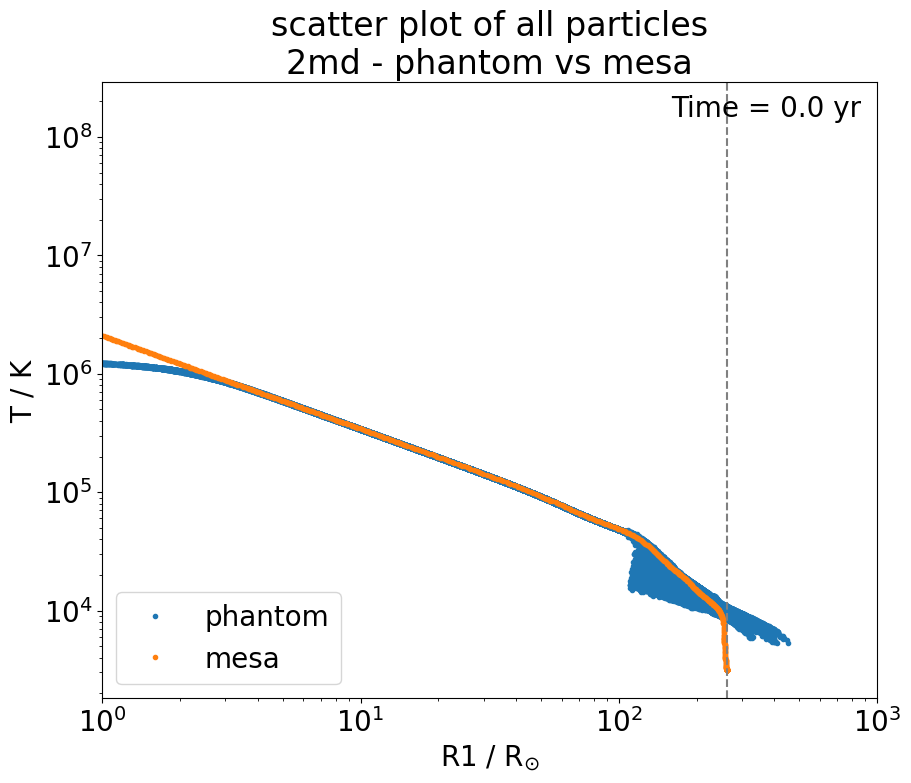

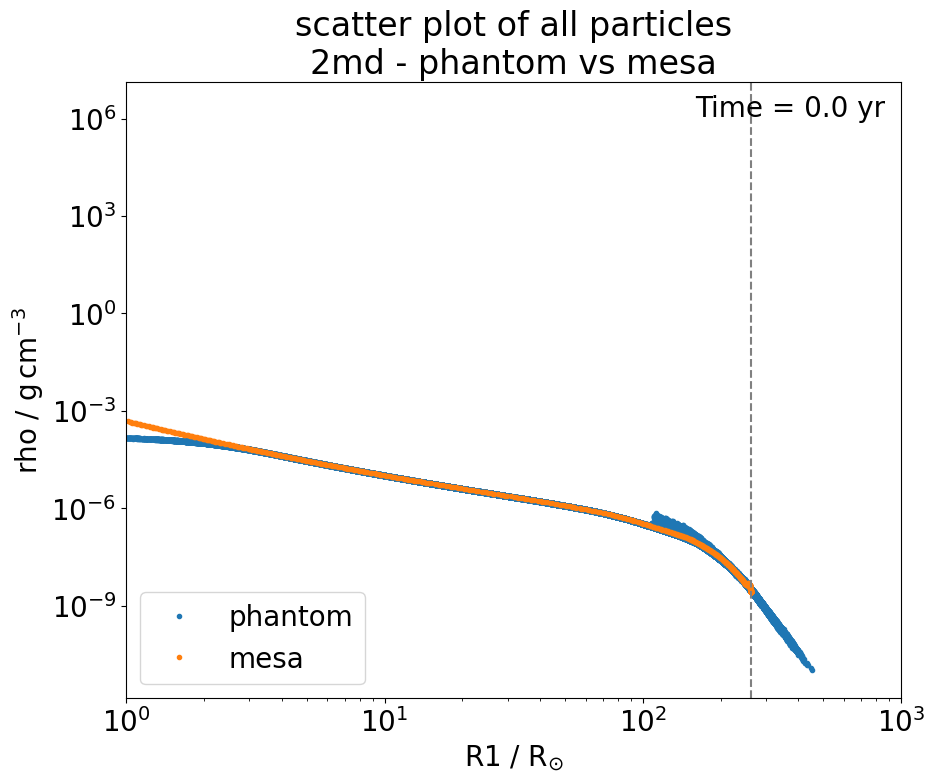

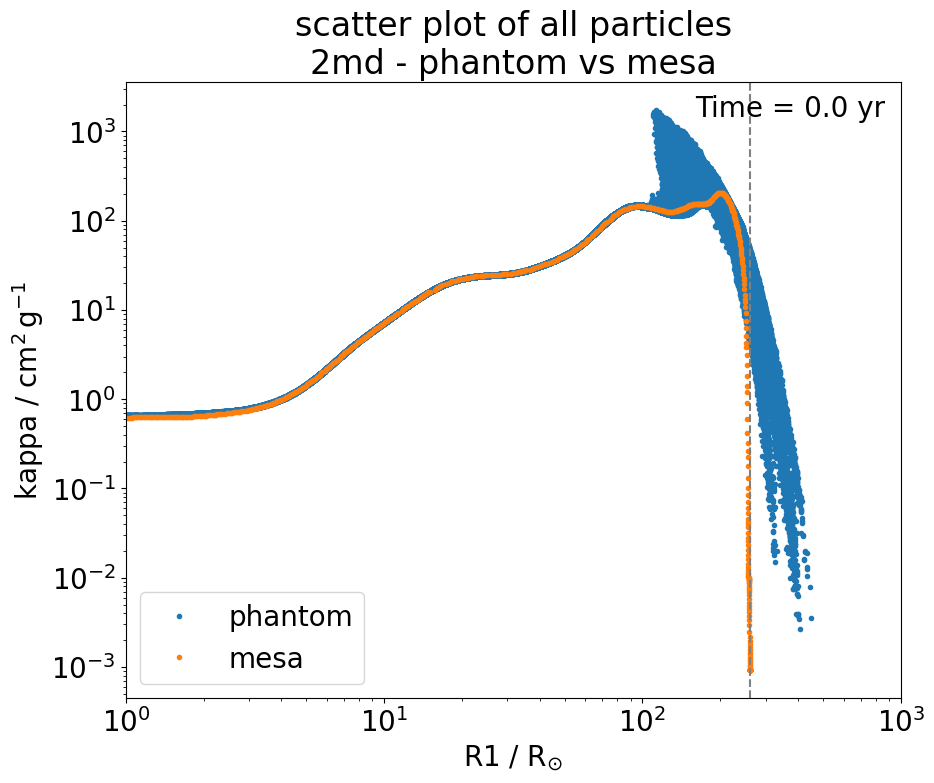

In [97]:
plt.close('all')
for what in ['T', 'rho', 'kappa']:
    fig, ax = plot_stuff(stuff, 'R1', what, mpdf, {'plot_title_suffix' : job_nickname + " - phantom vs mesa"})
    ax.loglog(stuff_mesa['R1'], stuff_mesa[what], '.', label='mesa')
    ax.axvline(x=stuff_mesa['R1'][0].value, color='grey', linestyle='dashed')
    ax.legend(['phantom', 'mesa'], loc='lower left')
    fig.savefig(f"{output_dir}/phantom-vs-mesa_2md_{what}-R1.png")
    plt.show(fig)

In [79]:
np.log(678e89)

211.44922056441047

In [88]:
%timeit np.log(123e34) - 211.44922056441047

645 ns ± 29 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [85]:
%timeit 123e34 / np.exp(211.44922056441047)

646 ns ± 44.8 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [10]:
(450*units.au).to_value(mpdf.units['dist'])

96729.71020188232

In [20]:
inds = (sdf['R1'] > (450*units.au).to_value(mpdf.units['dist']))
(np.sum(sdf[inds]['m'])*mpdf.units['mass']).to(units.Msun)

<Quantity 0.09406566 solMass>

In [ ]:
# Test
job_nickname= '2md'
job_profile = JOB_PROFILES_DICT[job_nickname]
job_name    = job_profile['job_name']
params      = job_profile['params']
eos_opacity = EoS_MESA_opacity(params, settings)
mpdf = mpdf_read(job_name, 0, eos_opacity, reset_xyz_by='R1')
mpdf.calc_sdf_params(['R1'])
sdf  = mpdf.data['gas']
inds = (sdf['R1'] > (450*units.au).to_value(mpdf.units['dist']))
(np.sum(sdf[inds]['m'])*mpdf.units['mass']).to(units.Msun)

In [10]:
mpdf.get_val('kappa').cgs

<Quantity [133.56917133, 133.57835947,  30.65612505, ..., 123.5633288 ,
           145.02782696, 145.43255533] cm2 / g>

In [9]:
stuff = {}
stuff['kappa'] = mpdf.get_val('kappa').cgs
stuff['R1'   ] = mpdf.get_val('R1').to(units.Rsun)
stuff['T'    ] = mpdf.get_val('T').to(units.K)
stuff['L'    ] = (4 * pi * stuff['R1']**2 * (const.sigma_sb * stuff['T']**4)).to(units.Lsun)
stuff['wtf'  ] = (4 * pi * stuff['R1']**2 * (const.sigma_sb * stuff['T'].value**2.5 * units.K**4)).to(units.Lsun)
stuff['rhokappa'] = mpdf.get_val('rho').cgs * mpdf.get_val('kappa').cgs
stuff['rhokappaR'] = mpdf.get_val('rho').cgs * mpdf.get_val('kappa').cgs * mpdf.get_val('R1').cgs

In [12]:
np.max(stuff['rhokappaR'] / (stuff['rhokappaR'] - 2) - 1)

<Quantity 5.93546797>

In [13]:
np.min(stuff['rhokappaR'] )

<Quantity 1.14535854>

In [94]:
(stuff_mesa['kappa'] * stuff_mesa['rho'] / stuff_mesa['R1']**2).cgs

<Quantity [7.36338304e-39, 7.36338305e-39, 7.36338311e-39, ...,
           1.93680116e-10, 2.86581724e-10, 4.54900567e-10] 1 / cm3>

In [83]:
(L_0 / R_0**2).cgs

<Quantity 6.85653849e+10 g / s3>

(0.0, 2.0)

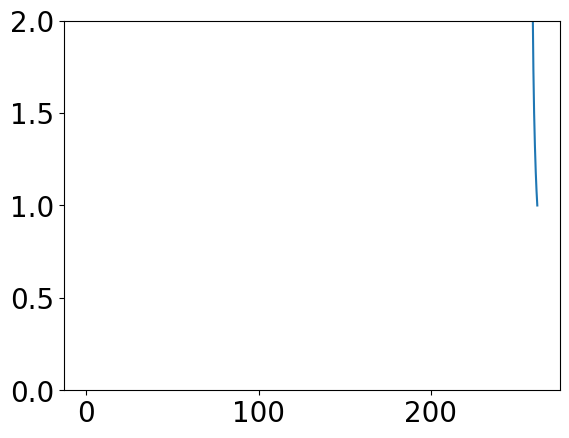

In [96]:
plt.plot(stuff_mesa['R1'], stuff_mesa['factor'])
plt.ylim(0., 2.)

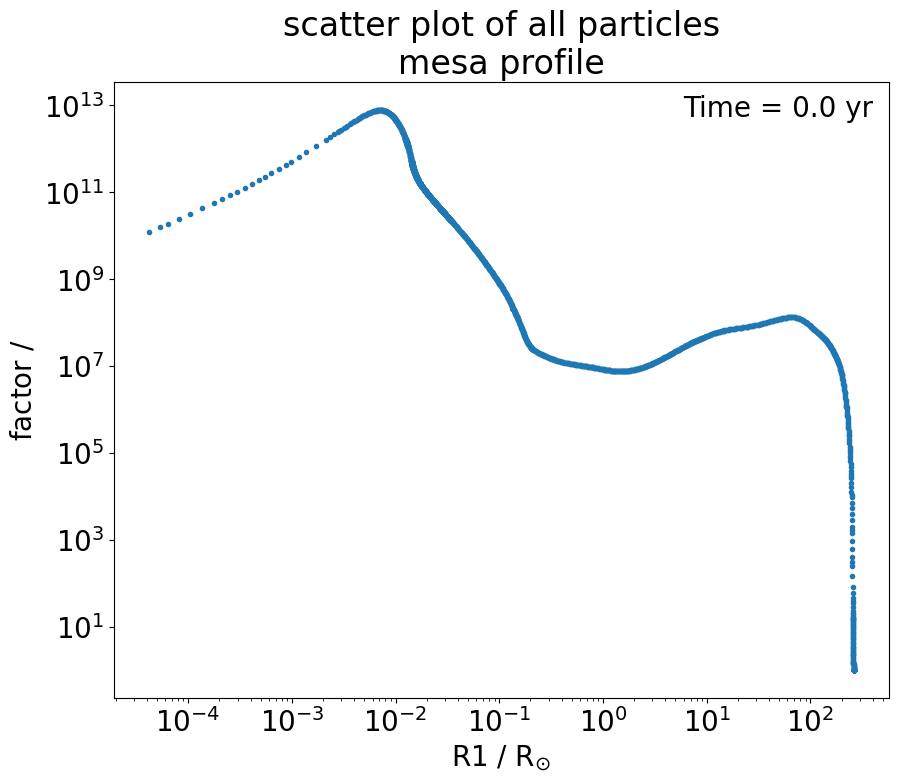

In [102]:
fig, ax = plot_stuff(stuff_mesa, 'R1', 'factor', mpdf, {'plot_title_suffix' : 'mesa profile'}, xlim=None)
fig.savefig(f"{output_dir}/temp.png")

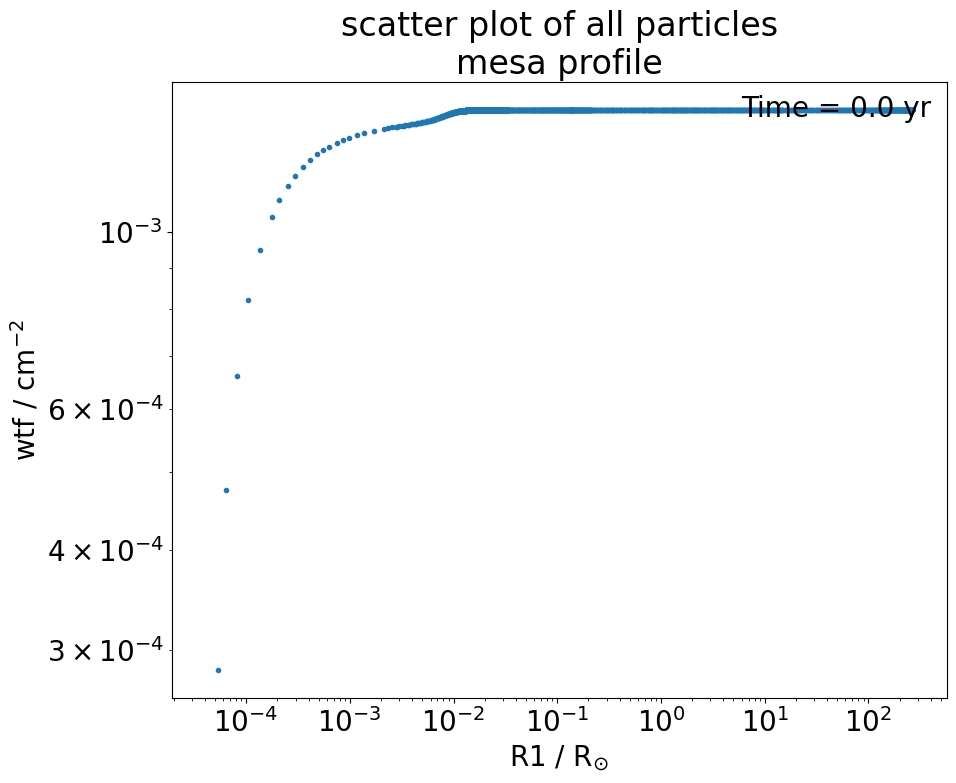

In [77]:
fig, ax = plot_stuff(stuff_mesa, 'R1', 'wtf', mpdf, {'plot_title_suffix' : 'mesa profile'}, xlim=None)
fig.savefig(f"{output_dir}/temp.png")

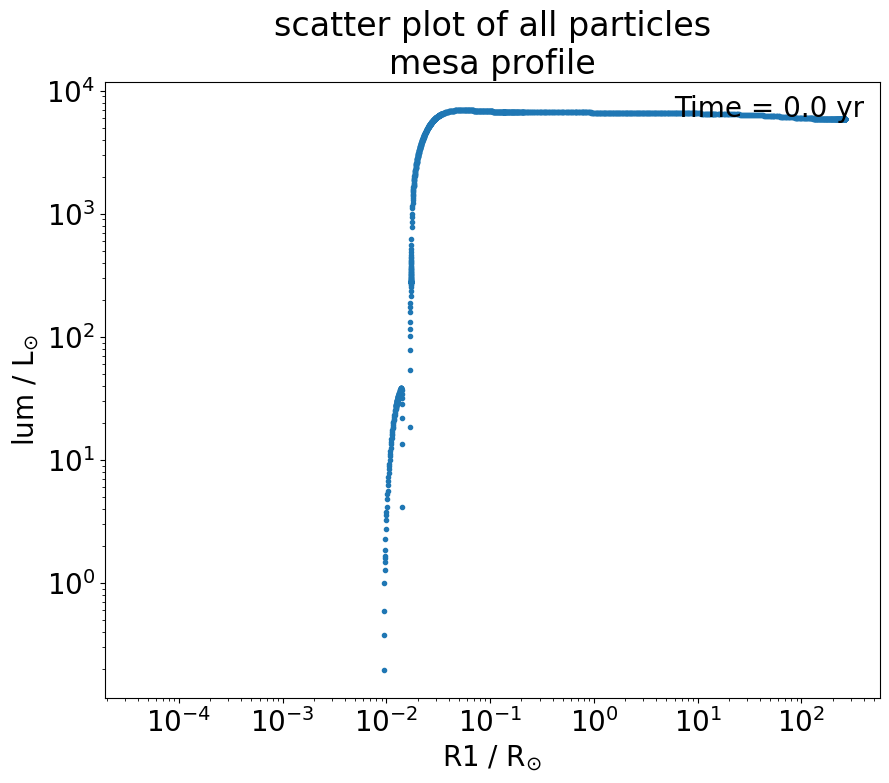

In [22]:
fig, ax = plot_stuff(stuff_mesa, 'R1', 'lum', mpdf, {'plot_title_suffix' : 'mesa profile'}, xlim=None)
fig.savefig(f"{output_dir}/temp.png")

In [23]:
stuff_mesa['T']

<Quantity [3.13480871e+03, 3.13480872e+03, 3.13480872e+03, ...,
           8.60392624e+07, 8.60381553e+07, 8.60371077e+07] K>

In [ ]:
eos_opacity.get_kappa(stuff_mesa)

In [24]:
stuff_mesa['lum'][:10]

<Quantity [5942.18103437, 5942.18103437, 5942.18103437, 5942.18103437,
           5942.18103437, 5942.18103437, 5942.18103437, 5942.18103437,
           5942.18103437, 5942.18103438] solLum>

In [22]:
stuff_mesa['L'][0], stuff_mesa['lum'][0]

(<Quantity 5963.57578799 solLum>, <Quantity 5942.18103437 solLum>)

In [ ]:
fig, ax = plot_stuff(stuff_mesa, 'R1', 'T', mpdf, {'plot_title_suffix' : 'mesa profile'}, xlim=None)
fig.savefig(f"{output_dir}/temp.png")

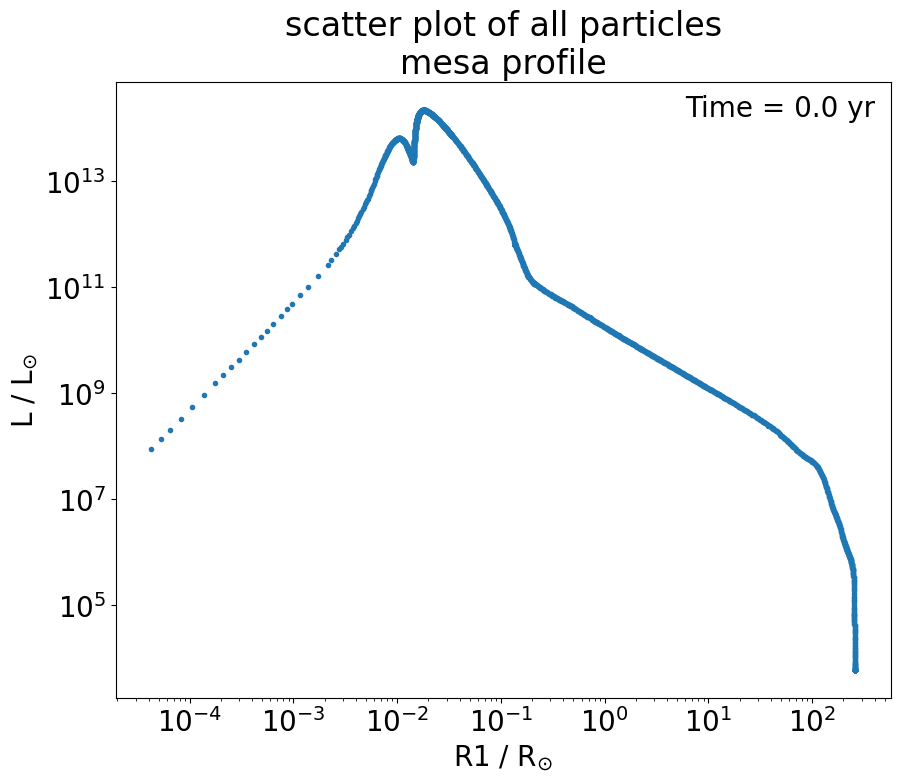

In [20]:
fig, ax = plot_stuff(stuff_mesa, 'R1', 'L', mpdf, {'plot_title_suffix' : 'mesa profile'}, xlim=None)
fig.savefig(f"{output_dir}/temp.png")

In [191]:
stuff_mesa['R1'][::100]

<Quantity [2.61808921e+02, 2.55975645e+02, 1.94075405e+02, 7.30456979e+01,
           1.04704689e+01, 2.71052753e+00, 7.73360559e-01, 1.88993556e-01,
           1.36619719e-01, 6.87743903e-02, 3.22256485e-02, 2.51569830e-02,
           2.00607213e-02, 1.71544759e-02, 1.59214561e-02, 1.47879525e-02,
           1.34108519e-02, 1.03266723e-02, 1.16591858e-03] solRad>

In [ ]:
# phantom plots

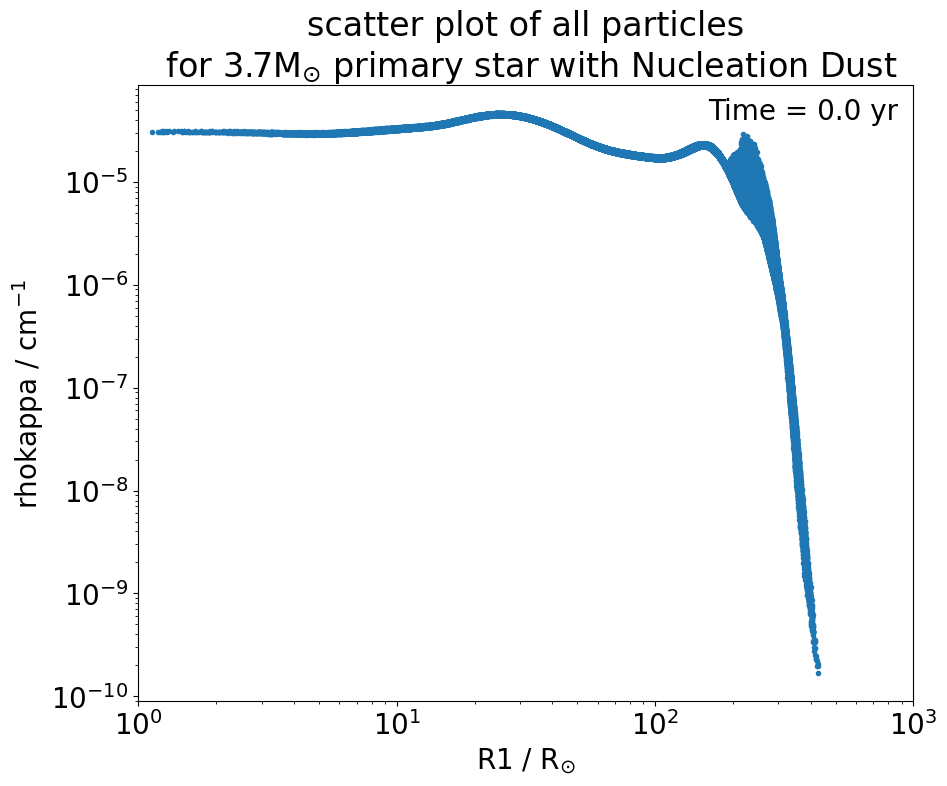

In [17]:
fig, ax = plot_stuff(stuff, 'R1', 'rhokappa', mpdf, job_profile)
fig.savefig(f"{output_dir}/temp.png")

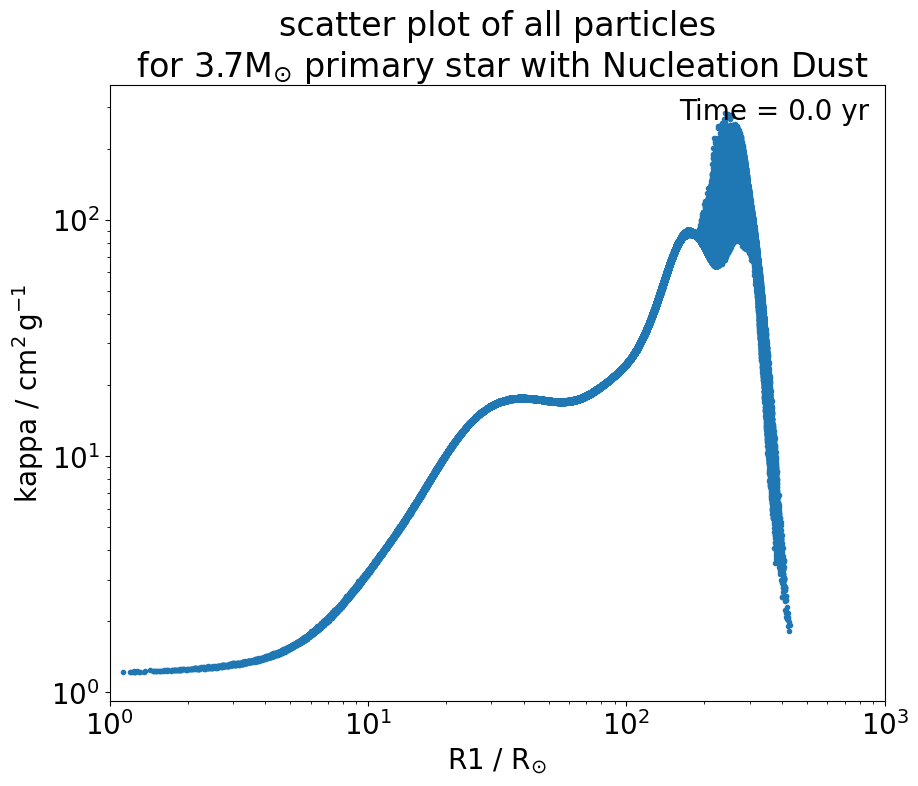

In [136]:
fig, ax = plot_stuff(stuff, 'R1', 'kappa', mpdf, job_profile)
fig.savefig(f"{output_dir}/temp.png")

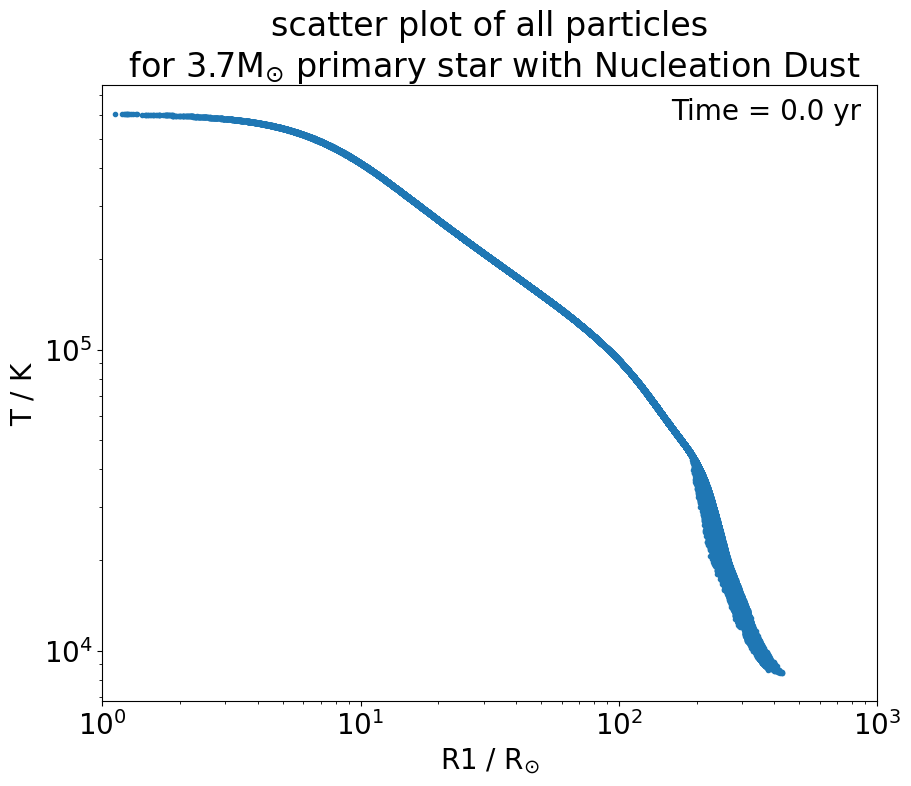

In [137]:
fig, ax = plot_stuff(stuff, 'R1', 'T', mpdf, job_profile)
fig.savefig(f"{output_dir}/temp.png")

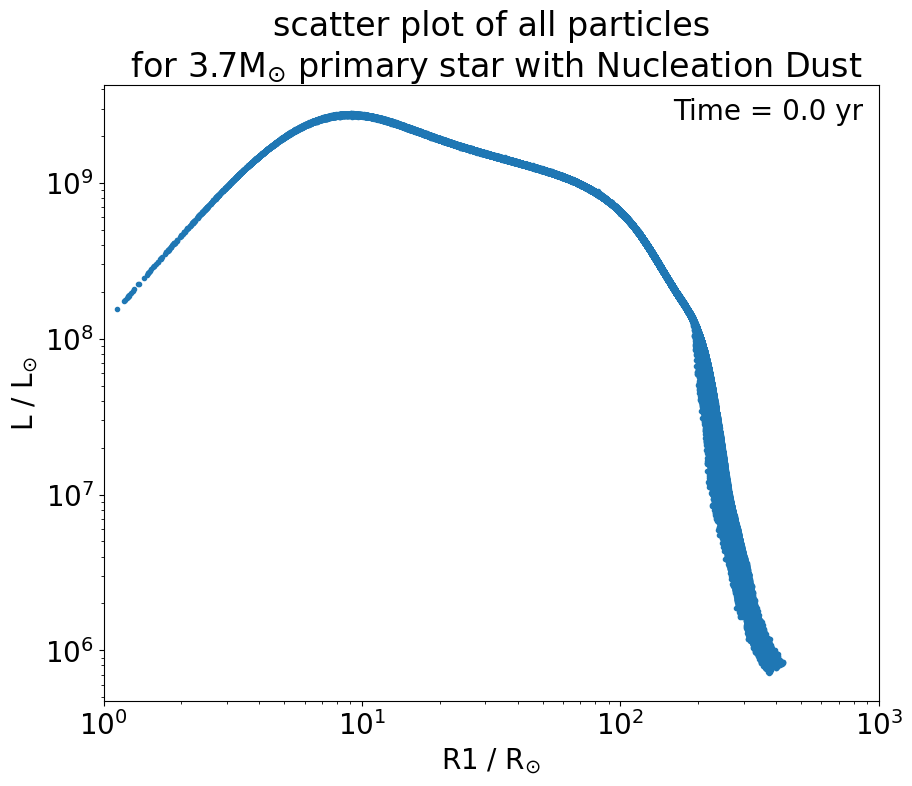

In [179]:
fig, ax = plot_stuff(stuff, 'R1', 'L', mpdf, job_profile)
fig.savefig(f"{output_dir}/temp.png")

(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'Cross-Section at z = 0.0\nresolution = 1.37e+06'}, xlabel='x', ylabel='y'>)

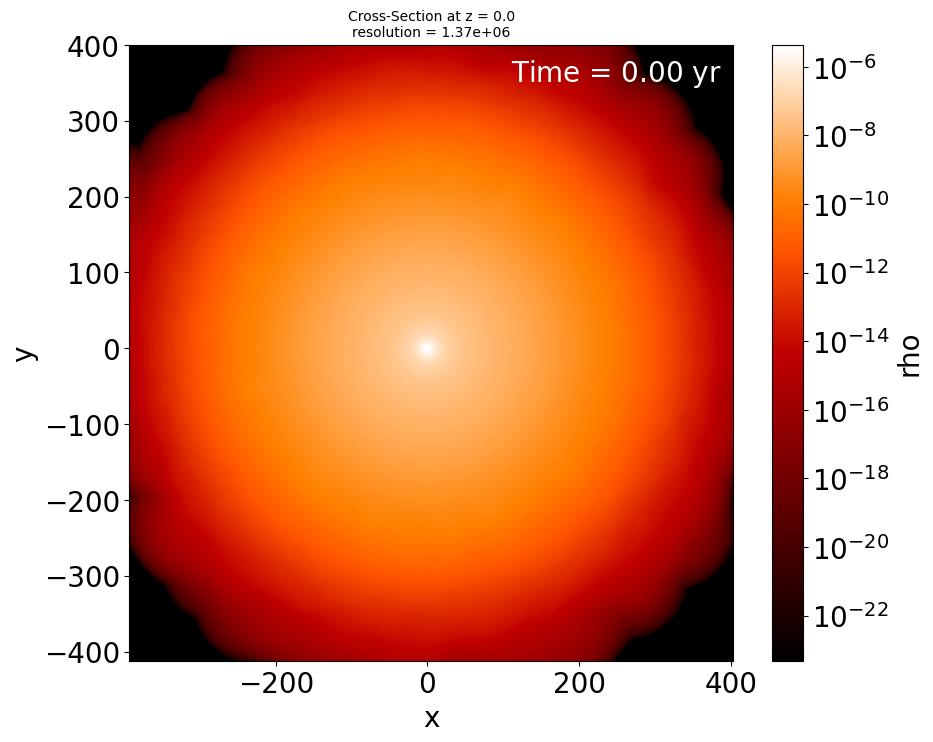

In [64]:
mpdf.plot_render()

In [76]:
rays, areas = get_xy_grids_of_rays(sdf, no_xy=(17, 17), frac_contained=99.99)
rays

array([[[-377.92692617, -384.18817369,    0.        ],
        [-377.92692617, -384.18817369,    1.        ]],

       [[-330.6860604 , -384.18817369,    0.        ],
        [-330.6860604 , -384.18817369,    1.        ]],

       [[-283.44519463, -384.18817369,    0.        ],
        [-283.44519463, -384.18817369,    1.        ]],

       ...,

       [[ 283.44519463,  384.18817369,    0.        ],
        [ 283.44519463,  384.18817369,    1.        ]],

       [[ 330.6860604 ,  384.18817369,    0.        ],
        [ 330.6860604 ,  384.18817369,    1.        ]],

       [[ 377.92692617,  384.18817369,    0.        ],
        [ 377.92692617,  384.18817369,    1.        ]]])

In [86]:
no_xy=(17, 17)
rays, areas = get_xy_grids_of_rays(sdf, no_xy=no_xy, frac_contained=99.99)
lums = []
for ray, area in zip(rays, areas):
    ans = integrate_along_ray(sdf, ray, srcfuncs)
    pts_order, pts_on_ray, dtaus_ordered, taus_ordered, dat, _, dat_bwd_inc = ans
    lums.append(dat * area) #* 4 * pi 
    if len(lums)%10 == 0:
        print(len(lums))

lums = (lums * mpdf.units['lum']).to(units.solLum)
lum = lums.sum()
lum

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280


<Quantity 273543.11736144 solLum>

In [267]:
# Test
job_nickname= '2md'
job_profile = JOB_PROFILES_DICT[job_nickname]
job_name    = job_profile['job_name']
params      = job_profile['params']
eos_opacity = EoS_MESA_opacity(params, settings)
mpdf = mpdf_read(job_name, 0, eos_opacity)
sdf  = mpdf.data['gas']
ray = mupl.get_rays(mpdf.data['sink'][['x', 'y', 'z']].iloc[0], np.array([0., 0., 1.]))
srcfuncs = mpdf.const['sigma_sb'] * sdf['T'] * sdf['T']**4 #/ (4 * pi)

*   Note   :    MyPhantomDataFrames.read():
	

	Reading filename='../photosphere/luis_2md/light_00000'


*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	Reseting Origin to CoM ([9.36841334e-13 3.02453466e-14 2.47169186e-14])...
*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	CoM location is now [ 0.00000000e+00  3.59257537e-16 -1.80945419e-16]
**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])


In [242]:
rays, areas = get_xy_grids_of_rays(sdf, no_xy=(17, 17))
lum = 0.
lums = []
i = 0
for ray, area in zip(rays, areas):
    ans = integrate_along_ray(sdf, ray, srcfuncs)
    pts_order, pts_on_ray, dtaus_ordered, taus_ordered, dat, _, dat_bwd_inc = ans
    lum += dat * area #* 4 * pi
    lums.append(dat*area)
    if i%50 == 0:
        print(i)
    i += 1

lum *= mpdf.units['lum']
lum.to(units.solLum)/1e6

0
50
100
150
200
250


<Quantity 441.35704836 solLum>

In [270]:
sdf['R0'] = (sdf['x']**2 + sdf['y']**2 + sdf['z']**2)**0.5
sdf['kappa_cgs'] = mupl.units_util.get_val_in_unit(sdf['kappa'], mpdf.units['opacity'], units.cm**2/units.g)
sdf.iloc[np.array(sdf['R0'] > 380)]

,iorig,x,y,z,temperature,gamma,vx,vy,vz,u,...,divv,poten,m,rho,v,vr,T,kappa_dust,R0,kappa_cgs
111,112,-333.503997,-196.819580,-58.476116,9564.784823,1.666667,0.002022,-0.018438,-0.002364,0.003201,...,-0.000093,-1.693614e-09,8.321285e-07,2.614854e-10,0.018698,0.007897,9564.784823,0.0,391.640549,14.434284
438,439,-345.411224,-39.160593,234.792402,6615.074278,1.666667,-0.002858,-0.019164,0.003671,0.001280,...,0.000110,-1.521432e-09,8.321285e-07,7.494553e-11,0.019720,0.006197,6615.074278,0.0,419.487709,0.090066
529,530,-440.836939,43.341735,14.205282,8963.335961,1.666667,-0.005641,-0.020930,0.005006,0.002863,...,0.000056,-1.577284e-09,8.321285e-07,1.240719e-10,0.022248,0.003725,8963.335961,0.0,443.190143,6.143182
906,907,-395.633312,-80.204010,59.915316,9112.569457,1.666667,0.007254,-0.013098,-0.003132,0.002439,...,-0.000450,-1.747112e-09,8.321285e-07,3.430497e-10,0.015297,-0.004918,9112.569457,0.0,408.103230,9.463218
1146,1147,-326.235900,-227.981242,124.129664,8781.755459,1.666667,-0.001352,-0.030919,0.006285,0.003117,...,0.000229,-1.493005e-09,8.321285e-07,6.204438e-11,0.031580,0.019836,8781.755459,0.0,416.909441,4.060100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1370136,1370137,-343.056122,176.931071,-58.063187,9766.805514,1.666667,-0.002968,-0.013376,-0.003774,0.003291,...,0.000198,-1.737399e-09,8.321285e-07,3.301369e-10,0.014211,-0.002893,9766.805514,0.0,390.337598,18.601888
1370938,1370939,-397.871879,7.405970,-112.754290,9627.812530,1.666667,0.006797,-0.021440,-0.003923,0.003228,...,-0.000230,-1.703030e-09,8.321285e-07,2.787013e-10,0.022831,-0.005853,9627.812530,0.0,413.606589,15.574132
1371122,1371123,-387.733425,41.448333,-4.518698,10750.967039,1.666667,-0.004583,-0.015976,-0.002957,0.003920,...,0.000020,-1.910990e-09,8.321285e-07,8.187017e-10,0.016882,0.002893,10750.967039,0.0,389.968706,51.144606
1371170,1371171,-294.004232,-242.893745,-147.497417,6726.268402,1.666667,0.002479,-0.022371,-0.000131,0.001310,...,0.000036,-1.485059e-09,8.321285e-07,6.082245e-11,0.022508,0.011554,6726.268402,0.0,408.890386,0.107749


(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'Cross-Section at z = 0.0\nresolution = 1.37e+06'}, xlabel='x', ylabel='y'>)

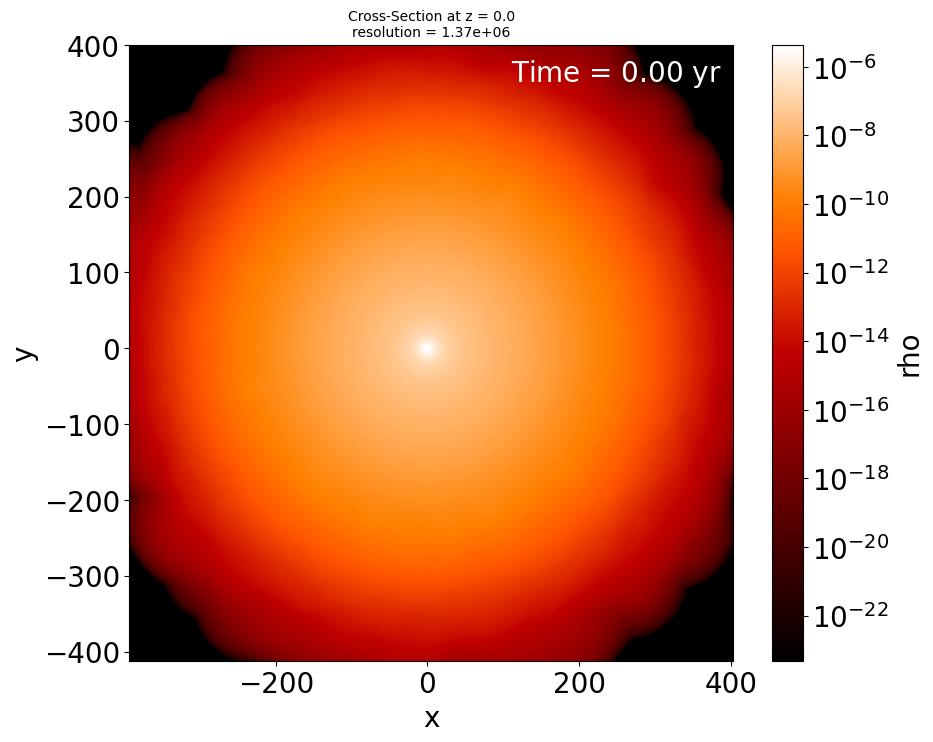

In [57]:
mpdf.plot_render()

In [244]:
rays, areas = get_xy_grids_of_rays(sdf, no_xy=(16, 16))
lum = 0.
i = 0
for ray, area in zip(rays, areas):
    ans = integrate_along_ray(sdf, ray, srcfuncs)
    pts_order, pts_on_ray, dtaus_ordered, taus_ordered, dat, _, dat_bwd_inc = ans
    lum += dat * area #* 4 * pi 
    if i%50 == 0:
        print(i)
    i += 1

lum *= mpdf.units['lum']
lum.to(units.solLum)

0
50
100
150
200
250


<Quantity 4.43158595e+08 solLum>

In [37]:
ans = integrate_along_ray(sdf, ray, srcfuncs)
pts_order, pts_on_ray, dtaus_ordered, taus_ordered, dat, _, dat_bwd_inc = ans
dat

backward dat =  1.1572865300327659e-15
	Contribution to L from photosphere and outwards is: 31.877263611212765 %
	50% Contributed correspond to tau = 1.6343815396229042
forward dat =  1.157286530032766e-15


1.157286530032766e-15

In [43]:

np.where(dat_bwd_inc / dat > 1e-7), dat_bwd_inc.shape

((array([  0,   1,   3,   4,   5,   6,   7,   8,  10,  12,  13,  14,  15,
          16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
          29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
          55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
          68,  69,  70,  71,  73,  74,  75,  77,  81,  82,  85, 308, 314,
         315, 319, 320, 322, 326, 329, 334, 335, 336, 338, 342, 343, 344,
         346, 348, 349, 350, 353, 354, 355, 356, 359, 363, 364, 365, 367,
         368, 369, 371, 373, 374, 375, 377, 381, 382, 383, 385, 387, 389,
         394, 396, 400, 401, 402, 403, 404, 405, 406, 408, 410, 412, 414,
         424, 429]),),
 (4694,))

In [7]:
def get_ph_vals(
    vals_names: list,
    mpdf: MyPhantomDataFrames,
    eos: mupl.eos_base.EoS_Base,
    rays_unit_vecs : np.ndarray, # (no_ray, 3)-shaped
    verbose: int,
):
    sdf_all = mpdf.data['gas']
    hs = np.array(sdf_all['h'])
    pts = np.array(sdf_all[['x', 'y', 'z']])    # (npart, 3)-shaped array
    kernel_radius = sdf_all.kernel.get_radius()

    plane_orig_vec = np.array(mpdf.data['sink'][['x', 'y', 'z']].iloc[0])

    # random direction in the sphere
    #rays_unit_vecs = get_rand_rays_unit_vec(no_ray)
    no_ray = len(rays_unit_vecs)
    
    vals_dict = {
        'tau_dust': np.full(no_ray, np.nan),
        'inner_dust_shell_rad': np.full(no_ray, np.nan) * mpdf.units['dist'],
    }
    
    for iray, ray_unit_vec in enumerate(rays_unit_vecs):
        ray = np.array([
            plane_orig_vec,
            plane_orig_vec + ray_unit_vec,
        ])
        
        pts_on_ray = mupl.get_closest_pt_on_line(pts, ray)
        sdf_selected_indices = (np.sum((pts - pts_on_ray)**2, axis=-1) <= (kernel_radius * hs)**2)
        sdf = sdf_all.iloc[sdf_selected_indices]
        
        pts_on_ray, dtaus, pts_order = get_optical_depth_by_ray_tracing_3D(sdf, ray)
        photosphere, waypts_list = get_photosphere_on_ray(
            pts_on_ray, dtaus, pts_order, sdf, ray,
            calc_params = vals_names,
            eos = eos,
            sdf_units = mpdf.units,
            photosphere_tau = PHOTOSPHERE_TAU,
            return_as_quantity=True,
            verbose = 1 if is_verbose(verbose, 'err') else 0,
        )
        for val_name in vals_names:
            if iray == 0:
                # init
                vals_dict[val_name] = np.full((*photosphere[val_name].shape, no_ray), np.nan)
                if isinstance(photosphere[val_name], units.quantity.Quantity):
                    vals_dict[val_name] *= photosphere[val_name].unit
            # save value
            vals_dict[val_name][iray] = photosphere[val_name]
            
            kappa_tol = 1e-7*(units.cm**2/units.g)
            kappa_tol_val = kappa_tol.to_value(mpdf.units['opacity'])
            pts_waypts_t = np.sum((pts_on_ray - ray[0]) * ray_unit_vec, axis=-1) # the higher, the more on the pt2 side (observer)
            # find the furtherest dust-containing particle on the observer's side
            last_dust_part_ordered_indices = np.where(np.logical_and(
                pts_waypts_t[pts_order] > 0,    # condition 1: on the observer's side (i.e. don't be further than the sink)
                sdf.iloc[pts_order]['kappa_dust'] > kappa_tol_val,    # condition 2: dust-containing
            ))[0]
            if len(last_dust_part_ordered_indices):
                # found the dust shell!
                last_dust_part_ordered_ind = last_dust_part_ordered_indices[-1]
                vals_dict['tau_dust'][iray] = np.sum(dtaus[pts_order][:last_dust_part_ordered_ind])
                vals_dict['inner_dust_shell_rad'][iray] = mupl.set_as_quantity(
                    pts_waypts_t[pts_order][last_dust_part_ordered_ind], mpdf.units['dist'])
    vals_dict['cos_theta'] = rays_unit_vecs[:, 2]
    vals_dict['ray_unit_vec'] = rays_unit_vecs
    
    return vals_dict

In [8]:
def get_photosphere_vals_rand_samples(
    job_nickname: str,
    file_index: int,
    no_ray: int,
    vals_names: list = ['R1', 'T'],
    cos_theta_sample_no: int|None = None,
    mpdf: MyPhantomDataFrames = None,
    verbose: int = 3,
) -> dict:
    
    job_profile = JOB_PROFILES_DICT[job_nickname]
    job_name    = job_profile['job_name']
    params      = job_profile['params']
    ieos = job_profile['ieos']
    eos  = get_eos(ieos, params, settings)
    eos_opacity = EoS_MESA_opacity(params, settings)
    
    mpdf = mpdf_read(
        job_name, file_index, eos_opacity, mpdf,
        kappa_gas = 2e-4*(units.cm**2/units.g) if file_index != 0 else 0.*(units.cm**2/units.g),
        verbose=verbose)

    if cos_theta_sample_no is None:

        rays_unit_vecs = get_rand_rays_unit_vec(no_ray)
        vals_dict = get_ph_vals(vals_names, mpdf, eos, rays_unit_vecs, verbose=verbose)
    
        if is_verbose(verbose, 'note'):
            say('note', f'{mpdf.get_filename()}', verbose,
                *[f'{val_name} = {np.average(vals_dict[val_name])} +/- {np.std(vals_dict[val_name])}' for val_name in vals_names]
            )
    else:
        # A fixed amount of rays per cos_theta interval will be generated
        #cos_theta_sample_no = 2
        ray_per_cos_theta = int(no_ray/cos_theta_sample_no)
        cos_theta_delta = 1. / cos_theta_sample_no
        cos_thetas = np.linspace(-1+cos_theta_delta, 1-cos_theta_delta, cos_theta_sample_no)
        vals_by_cos_thetas = []
    
        for i, cos_theta_mid in enumerate(cos_thetas):
            rays_unit_vecs = get_rand_rays_unit_vec(ray_per_cos_theta, cos_theta_mid, cos_theta_delta)
            vals_dict = get_ph_vals(vals_names, mpdf, eos, rays_unit_vecs, verbose=verbose)
            #vals_dict['cos_theta'] = rays_unit_vecs[:, 2]
            vals_by_cos_thetas.append(vals_dict)
        
            if is_verbose(verbose, 'note'):
                say('note', f'cos_theta_mid = {cos_theta_mid}', verbose,
                    *[f'{val_name} = {np.average(vals_dict[val_name])} +/- {np.std(vals_dict[val_name])}' for val_name in vals_names]
                )
        
        vals_dict = { key: np.concatenate([data[key] for data in vals_by_cos_thetas]) for key in vals_by_cos_thetas[0].keys()}

    return vals_dict

.

## Main

.


In [10]:
if __name__ == '__main__':
    mpdf = MyPhantomDataFrames()
    for job_nickname in ['2md']:  # '2md', 
        for file_index in [4800, 6400]: # [0, 2000, 8000, 17600]
            vals_dict = get_photosphere_vals_rand_samples(
                job_nickname, file_index, no_ray, vals_names=['R1', 'T', 'rho', 'kappa', 'nneigh', 'vr'], cos_theta_sample_no=None, mpdf=mpdf)
            with open(f"{mpdf.get_filename()}__photosphere-vals.json", 'w') as f:
                json_dump(vals_dict, f, metadata)
    if is_verbose(verbose, 'note'):
        say('note', '__main__', verbose, f"\n\n\n*** All Done. ***\n\n\n")

*   Note   :    MyPhantomDataFrames.read():
	

	Reading filename='../photosphere/luis_2md/light_04800'


*   Note   :    MyPhantomDataFrames.read():
	CoM significantly deviates from the origin with distance of 3.720647492094738.
	Consider use reset_xyz_by_CoM=True option when read?
**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])
91705 1356310
*   Note   :    ../photosphere/luis_2md/light_04800:
	R1 = 27094.61603459788 udist +/- 1954.4331316030925 udist
	T = 513.0249707436063 K +/- 50.96035232156766 K
	rho = 1.7947891556866646e-16 umass / udist3 +/- 4.520868390693096e-17 umass / udist3
	kappa = 2554526279067.905 